# Capstone 3 - Data Cleaning & Wrangling

### Table of contents

* [Motivation](#motivation)
    * [Preparation](#preparation)
* [Cleaning & wrangling](#cleaning)
    * [SONYC data](#sonyc)
        * [Initial cleaning](#sonyc-initial)
        * [Dates](#sonyc-dates)
        * [Sound taxonomy](#sound-tax)
        * [Audio files](#audio-files)
            * [Presence columns](#presence-cols)
            * [Proximity columns](#proximity-cols)
        * [Coordinate data](#coordinate-data)
    * [School district shapefile](#sdshp)
    * [School points shapefile](#spshp)
    * [Building a map](#map)
        * [Closest schools](#closest-schools)
        * [Map of schools within coverage area](#coverage-map)
    * [School quality reports](#school-quality)
        * [Load school quality reports](#load-quality-data)
        * [Combining school metrics](#combine-school-metrics)
* [Initial EDA](#initial-eda)
* [Final data cleaning before saving](#final-cleaning)
    * [Data validation](#data-validation)
    * [Check for overlap](#check-overlap)
    * [Data range validation](#data-range-validation)
    * [Check temporal coverage](#temporal-coverage)
* [Conclusion](#conclusion)
    * [Save data](#save-data)

## Motivation <a name="motivation"></a>
This project aims to understand how environmental noise has affected school performance in New York City between the years 2016 and 2019.

### Preparation <a name="preparation"></a>
Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import geopandas as gpd
from shapely.geometry import Point

# Cleaning & wrangling <a name="cleaning"></a>

## SONYC data <a name="sonyc"></a>

We are using the dataset SONYC-UST v2.3, obtained from the [SONYC website](https://wp.nyu.edu/sonyc/resources/).

Documentation [here](https://zenodo.org/records/3966543).

In [2]:
# Load SONYC data
noise_data = pd.read_csv("annotations.csv")

In [3]:
# Check dataframe
noise_data.head()

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
0,test,0,00_026884.wav,-6,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,1,0,-1,-1,-1,-1,-1
1,test,0,00_026884.wav,-4,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,test,0,00_026884.wav,-3,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
3,test,0,00_026884.wav,-1,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,test,0,00_026884.wav,0,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,0,1,0,0,0,0,0


In [4]:
# Check dataframe info
noise_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62022 entries, 0 to 62021
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   split                                         62022 non-null  object 
 1   sensor_id                                     62022 non-null  int64  
 2   audio_filename                                62022 non-null  object 
 3   annotator_id                                  62022 non-null  int64  
 4   borough                                       62022 non-null  int64  
 5   block                                         62022 non-null  int64  
 6   latitude                                      62022 non-null  float64
 7   longitude                                     62022 non-null  float64
 8   year                                          62022 non-null  int64  
 9   week                                          62022 non-null 

### Initial cleaning <a name="sonyc-initial"></a>

#### Drop columns
There are a few columns that we can remove outright since they are not informative for our data analysis. These are:
- `split`: The data split. (train, validate, test)
- `annotator_id`: The anonymous ID of the annotator.

In [5]:
# Create a list of columns to drop.
drop_cols = ['split', 'annotator_id']

# Drop the columns
noise_data = noise_data.drop(drop_cols, axis=1)

Note that while `audio_filename` might not seem important for our analysis purposes, we will need to retain it while cleaning the data. Multiple SONYC team members worked on annotating the same recordings, meaning multiple annotation rows exist for one particular audio recording. We would like to control for noise in the data where we can by eliminating any duplicate information for one audio recording. We can drop this column after we are finished cleaning the data. 

#### Check for null values

In [6]:
# Check whether any null values exist in the dataframe
noise_data.isnull().values.any()

False

#### Date and time conversion
Let's put the time data into a usable format. Currently, the date and time of each recording are recorded as follows:
- `year`: the year the recording is from
- `week`: the week of the year the recording is from
- `day`: the day of the week the recording is from, with Monday as the start (`0`=Monday)
- `hour`: the hour of the day the recording is from

In [7]:
# Create dates directly in the dataframe operation
noise_data['date'] = noise_data.apply(
    lambda row: (
        # Start with January 1st of the year
        datetime(int(row['year']), 1, 1) +
        # Find first Monday
        timedelta(days=(-datetime(int(row['year']), 1, 1).weekday())) +
        # Adjust if Jan 1 is Fri/Sat/Sun
        timedelta(weeks=1 if datetime(int(row['year']), 1, 1).weekday() > 3 else 0) +
        # Add weeks and days to get to target date
        timedelta(weeks=int(row['week']-1), days=int(row['day']))
    ),
    axis=1
)

# Create times in 24-hour format
noise_data['time'] = noise_data['hour'].apply(lambda hour: f"{hour:02}:00")

Now, we will add validation checks to make sure that our dates converted correctly.

In [8]:
min(noise_data['year'])

2016

In [9]:
max(noise_data['year'])

2019

We know that the earliest date in our `noise_data` dataset should be from 2016, and our latest date should be from 2019.

In [10]:
# Validation checks
print("Date range in dataset:")
print(f"Earliest date: {noise_data['date'].min()}")
print(f"Latest date: {noise_data['date'].max()}")

print("\nCounts by year:")
print(noise_data['date'].dt.year.value_counts().sort_index())

# Check for any dates before 2016
early_dates = noise_data[noise_data['date'].dt.year < 2016]
if len(early_dates) > 0:
    print("\nWARNING: Found dates before 2016:")
    print(early_dates[['date', 'year', 'week', 'day']].head())

# Check for any dates before 2016
late_dates = noise_data[noise_data['date'].dt.year > 2019]
if len(late_dates) > 0:
    print("\nWARNING: Found dates after 2019:")
    print(early_dates[['date', 'year', 'week', 'day']].head())

Date range in dataset:
Earliest date: 2016-05-07 00:00:00
Latest date: 2019-12-29 00:00:00

Counts by year:
date
2016     2480
2017    29247
2018    21455
2019     8840
Name: count, dtype: int64


In [11]:
# Check new column
noise_data[['date', 'time']].head()

,date,time
0,2019-10-25,08:00
1,2019-10-25,08:00
2,2019-10-25,08:00
3,2019-10-25,08:00
4,2019-10-25,08:00


Additionally, we'll add `month`, `weekday`, and `is_school_day` columns to our dataframe to help with analysis.

In [12]:
noise_data['month'] = noise_data['date'].dt.to_period('M')
noise_data['weekday'] = noise_data['date'].dt.weekday
noise_data['is_school_day'] = noise_data['weekday'].between(0, 4)

We no longer need the `week` column, so let's drop it.

In [13]:
noise_data = noise_data.drop('week', axis=1)

### Dates <a name="sonyc-dates"></a>
We will be looking at school performance data from the start of the 2016-2017 school year through the end of the 2018-2019 school year. Let's exclude dates in our SONYC dataset that are outside of this range.

In [14]:
# Set start/end dates for school years
start_date = "2016-08-01"
end_date = "2019-06-30"

In [15]:
noise_data = noise_data[(noise_data['date'] >= start_date) & (noise_data['date'] <= end_date)]

### Sound taxonomy <a name="sound-tax"></a>
Our `noise_data` dataframe has multiple columns representing categories from SONYC's sound taxonomy. The naming scheme (from SONYC's [Zenodo page documentation](https://zenodo.org/records/3966543)) for these columns is as follows:
- `<coarse_id>-<fine_id>_<fine_name>_presence`: Columns of this form indicate the presence of fine-level class. `1` if present, `0` if not present. If `-1`, then the class was not labeled in this annotation because the annotation was performed by a SONYC team member who only annotated one coarse group of classes at a time when annotating the verified subset.
- `<coarse_id>_<coarse_name>_presence`: Columns of this form indicate the presence of a coarse-level class. `1` if present, `0` if not present. If `-1`, then the class was not labeled in this annotation because the annotation was performed by a SONYC team member who only annotated one coarse group of classes at a time when annotating the verified subset. These columns are computed from the fine-level class presence columns and are presented here for convenience when training on only coarse-level classes.
- `<coarse_id>-<fine_id>_<fine_name>_proximity`: Columns of this form indicate the proximity of a fine-level class. After indicating the presence of a fine-level class, citizen science annotators were asked to indicate the proximity of the sound event to the sensor. Only the citizen science volunteers performed this task, and therefore this data is not included in the verified annotations. This column may take on one of the following four values: (`near`, `far`, `notsure`, `-1`). If `-1`, then the proximity was not annotated because either the annotation was not performed by a citizen science volunteer, or the citizen science volunteer did not indicate the presence of the class.

Let's check the data types for these columns:

In [16]:
sound_taxonomy_cols = [col for col in noise_data.columns if '_presence' in col or '_proximity' in col]
noise_data[sound_taxonomy_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 58096 entries, 8 to 62021
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   1-1_small-sounding-engine_presence            58096 non-null  int64 
 1   1-2_medium-sounding-engine_presence           58096 non-null  int64 
 2   1-3_large-sounding-engine_presence            58096 non-null  int64 
 3   1-X_engine-of-uncertain-size_presence         58096 non-null  int64 
 4   2-1_rock-drill_presence                       58096 non-null  int64 
 5   2-2_jackhammer_presence                       58096 non-null  int64 
 6   2-3_hoe-ram_presence                          58096 non-null  int64 
 7   2-4_pile-driver_presence                      58096 non-null  int64 
 8   2-X_other-unknown-impact-machinery_presence   58096 non-null  int64 
 9   3-1_non-machinery-impact_presence             58096 non-null  int64 
 10  4-1

Note that columns ending with `_presence` are of type integer, while columns ending with `_proximity` are of type object. This is in line with what we would expect, since `_presence` columns take on one of three integer values &mdash; `1`, `0`, or `-1` &mdash; while `_proximity` columns take on one of four values &mdash; `near`, `far`, `notsure`, or `-1`, where `-1` means that the proximity was not annotated "because either the annotation was not performed by a citizen science volunteer, or the citizen science volunteer did not indicate the presence of the class."

Let's create a dictionary for this sound hierarchy. We can use this dictionary to facilitate cleaning and analysis.

In [17]:
hierarchy = {
    '1_engine': ['1-1_small-sounding-engine', '1-2_medium-sounding-engine', 
                '1-3_large-sounding-engine', '1-X_engine-of-uncertain-size'],
    '2_machinery-impact': ['2-1_rock-drill', '2-2_jackhammer', '2-3_hoe-ram', 
                         '2-4_pile-driver', '2-X_other-unknown-impact-machinery'],
    '3_non-machinery-impact': ['3-1_non-machinery-impact'],
    '4_powered-saw': ['4-1_chainsaw', '4-2_small-medium-rotating-saw', 
                     '4-3_large-rotating-saw', '4-X_other-unknown-powered-saw'],
    '5_alert-signal': ['5-1_car-horn', '5-2_car-alarm', '5-3_siren', 
                      '5-4_reverse-beeper', '5-X_other-unknown-alert-signal'],
    '6_music': ['6-1_stationary-music', '6-2_mobile-music', '6-3_ice-cream-truck',
               '6-X_music-from-uncertain-source'],
    '7_human-voice': ['7-1_person-or-small-group-talking', '7-2_person-or-small-group-shouting',
                     '7-3_large-crowd', '7-4_amplified-speech', '7-X_other-unknown-human-voice'],
    '8_dog': ['8-1_dog-barking-whining']
}

### Audio files <a name="audio-files"></a>
In our dataset, multiple annotations exist for a single sound file, as we can see here by taking the `value_counts` for `audio_filename`:

In [18]:
annotation_counts = noise_data['audio_filename'].value_counts()
annotation_counts

audio_filename
04_026992.wav    22
01_010420.wav    20
00_000066.wav    20
04_003239.wav    14
04_010714.wav    14
                 ..
25_011182.wav     3
25_011189.wav     3
25_011212.wav     3
25_011272.wav     3
46_020853.wav     3
Name: count, Length: 17983, dtype: int64

We are going to simplify our dataframe so that only one "annotation" exists per audio file. However, we will need to weight each file's annotation by $1/n$, where $n$ is the number of annotations.

#### `_presence` columns <a name="presence-cols"></a>

To account for differences in annotations in the `_presence` columns, we could average these annotations and then convert them to booleans.<br>
However, we may also wish to account for annotations where the presence of a specific sound is ambiguous. The source of a sound may not always be clear; particularly for sounds that are mechanical in nature. For this reason, we will be using the keys in our `hierarchy` dictionary to create simplified columns indicating the presence or absence of a noise.

Since `-1` represents missing data, we will treat records with `-1` in `_presence` columns identically to how we treat records with `0`.
Let's replace all instances of `-1` in these columns with `0`.

In [19]:
sounds_presence = [col for col in noise_data.columns if '_presence' in col]
noise_data[sounds_presence] = noise_data[sounds_presence].replace(-1, 0)

Let's now write a function that will simplify our annotations in the `_presence` columns of our `noise_data` dataframe.

In [20]:
# Define metadata columns to preserve
metadata_cols = [
    'audio_filename', 'sensor_id', 'borough', 'block', 
    'latitude', 'longitude', 'year', 'day', 'hour',
    'date', 'time', 'month', 'weekday', 'is_school_day'
]

In [21]:
def simplify_presence_annotations(noise_data, threshold=0.5):
    """
    Simplifies presence annotations by:
    1. Using a threshold to determine final presence classification
    2. Aggregating to high-level categories
    """
    pd.options.mode.chained_assignment = None  # Temporarily disable warning
    
    # Create a copy of the dataframe
    df = noise_data.copy()
    
    # Get presence columns
    presence_cols = [col for col in df.columns if '_presence' in col]
    
    # Create aggregation dictionary
    agg_dict = {}
    
    # For metadata columns, use first value
    existing_metadata = [col for col in metadata_cols if col in df.columns]
    for col in existing_metadata:
        if col != 'audio_filename':
            agg_dict[col] = 'first'
            
    # For presence columns, use mean
    for col in presence_cols:
        agg_dict[col] = 'mean'
    
    # Group by audio_filename and aggregate
    df = df.groupby('audio_filename', as_index=False).agg(agg_dict)
    
    # Apply threshold to presence columns
    for col in presence_cols:
        df[col] = (df[col] > threshold).astype(int)
    
    # Create high-level category columns
    for main_category, subcategories in hierarchy.items():
        # Convert subcategory names to column names
        subcategory_cols = [f"{sub}_presence" for sub in subcategories]
        existing_subcols = [col for col in subcategory_cols if col in df.columns]
        if existing_subcols:
            # If any subcategory is present (1), mark the main category as present
            df[f"{main_category}_presence"] = (df[existing_subcols].max(axis=1) > 0).astype(int)
    
    # Keep only high-level categories and metadata
    columns_to_keep = (
        existing_metadata +  # Metadata columns
        [f"{cat}_presence" for cat in hierarchy.keys()]  # High-level categories
    )
    
    df_simplified = df[columns_to_keep]
    
    # Add annotation count
    df_simplified['annotation_count'] = noise_data.groupby('audio_filename').size().reindex(df_simplified['audio_filename']).values
    
    pd.options.mode.chained_assignment = 'warn'  # Re-enable warning
    
    return df_simplified

In [22]:
df_presence = simplify_presence_annotations(noise_data, threshold=0.07)

#### `_proximity` columns <a name="proximity-cols"></a>

Just as we did with `_presence` columns, let's create a list of columns containing `_proximity`.

In [23]:
sounds_proximity = [col for col in noise_data.columns if '_proximity' in col]
sounds_proximity

['1-1_small-sounding-engine_proximity',
 '1-2_medium-sounding-engine_proximity',
 '1-3_large-sounding-engine_proximity',
 '1-X_engine-of-uncertain-size_proximity',
 '2-1_rock-drill_proximity',
 '2-2_jackhammer_proximity',
 '2-3_hoe-ram_proximity',
 '2-4_pile-driver_proximity',
 '2-X_other-unknown-impact-machinery_proximity',
 '3-1_non-machinery-impact_proximity',
 '4-1_chainsaw_proximity',
 '4-2_small-medium-rotating-saw_proximity',
 '4-3_large-rotating-saw_proximity',
 '4-X_other-unknown-powered-saw_proximity',
 '5-1_car-horn_proximity',
 '5-2_car-alarm_proximity',
 '5-3_siren_proximity',
 '5-4_reverse-beeper_proximity',
 '5-X_other-unknown-alert-signal_proximity',
 '6-1_stationary-music_proximity',
 '6-2_mobile-music_proximity',
 '6-3_ice-cream-truck_proximity',
 '6-X_music-from-uncertain-source_proximity',
 '7-1_person-or-small-group-talking_proximity',
 '7-2_person-or-small-group-shouting_proximity',
 '7-3_large-crowd_proximity',
 '7-4_amplified-speech_proximity',
 '7-X_other-unkno

In [24]:
def simplify_proximity_annotations(noise_data, threshold=0.5):
    """
    Simplifies proximity annotations by:
    1. One-hot encoding 'near' and 'far' values
    2. Ignoring 'notsure' and '-1' values
    3. Using a threshold to determine final near/far classification
    """
    
    pd.options.mode.chained_assignment = None  # Temporarily disable warning
    
    # Create a copy of the dataframe
    df = noise_data.copy()
    
    # Get proximity columns
    proximity_cols = [col for col in df.columns if '_proximity' in col]
    
    # Create dataframe for storing one-hot encoded values
    df_encoded = df.copy()
    
    # One-hot encode proximity values
    for col in proximity_cols:
        base_col = col.replace('_proximity', '')
        
        # Create near/far indicator columns (1 if the value matches, 0 if not)
        df_encoded[f"{base_col}_near"] = (df[col] == 'near').astype(float)
        df_encoded[f"{base_col}_far"] = (df[col] == 'far').astype(float)
    
    # Get all near/far columns
    near_cols = [col for col in df_encoded.columns if col.endswith('_near')]
    far_cols = [col for col in df_encoded.columns if col.endswith('_far')]
    
    # Create aggregation dictionary
    agg_dict = {}
    
    # For metadata columns, use first value
    existing_metadata = [col for col in metadata_cols if col in df.columns]
    for col in existing_metadata:
        if col != 'audio_filename':
            agg_dict[col] = 'first'
            
    # For near/far columns, use mean and then threshold
    for col in near_cols + far_cols:
        agg_dict[col] = 'mean'
    
    # Group by audio_filename and aggregate
    df_encoded = df_encoded.groupby('audio_filename', as_index=False).agg(agg_dict)
    
    # Apply threshold to near/far columns
    for col in near_cols + far_cols:
        df_encoded[col] = (df_encoded[col] > threshold).astype(int)
    
    # Create high-level category columns for both near and far
    for main_category, subcategories in hierarchy.items():
        # Handle near annotations
        near_subcols = [f"{sub}_near" for sub in subcategories]
        existing_near_subcols = [col for col in near_subcols if col in df_encoded.columns]
        if existing_near_subcols:
            # For high-level categories, if any subcategory is 1, the category is 1
            df_encoded[f"{main_category}_near"] = (df_encoded[existing_near_subcols].max(axis=1) > 0).astype(int)
            
        # Handle far annotations
        far_subcols = [f"{sub}_far" for sub in subcategories]
        existing_far_subcols = [col for col in far_subcols if col in df_encoded.columns]
        if existing_far_subcols:
            df_encoded[f"{main_category}_far"] = (df_encoded[existing_far_subcols].max(axis=1) > 0).astype(int)
    
    # Keep only high-level categories and metadata
    columns_to_keep = (
        existing_metadata +  # Metadata columns
        [f"{cat}_near" for cat in hierarchy.keys()] +  # High-level near categories
        [f"{cat}_far" for cat in hierarchy.keys()]     # High-level far categories
    )
    
    df_simplified = df_encoded[columns_to_keep]
    
    # Add annotation count
    df_simplified['annotation_count'] = df.groupby('audio_filename').size().reindex(df_simplified['audio_filename']).values
    
    pd.options.mode.chained_assignment = 'warn'  # Re-enable warning
    
    return df_simplified

In [25]:
# Process proximity annotations with threshold (adjust threshold as needed)
df_proximity = simplify_proximity_annotations(noise_data, threshold=0.3)

#### Zero rows analysis
We will look at both `df_presence` and `df_proximity` to see if the percentage of rows consisting of all zeros is reasonable for our analysis. (Ideally, we would like fewer than 10% of rows to consist of all zeros. If this is not the case, then we will adjust our threshold to be lower.)

In [26]:
cols_to_check = [col for col in df_presence.columns 
                if col.endswith('_presence')]
    
# Find rows where all specified columns are 0
all_zeros = df_presence[cols_to_check].eq(0).all(axis=1)
zero_rows = df_presence[all_zeros]
    
# Calculate statistics
total_rows = len(df_presence)
zero_count = len(zero_rows)
    
# Get average annotation count for zero rows
avg_annotations_zero = zero_rows['annotation_count'].mean()

analysis = {
    'total_rows': total_rows,
    'zero_rows': zero_count,
    'zero_percentage': (zero_count / total_rows) * 100 if total_rows > 0 else 0,
    'avg_annotations_per_zero_row': avg_annotations_zero,
    'zero_rows_by_annotation_count': zero_rows['annotation_count'].value_counts().sort_index().to_dict() ,
    'columns_checked': len(cols_to_check)
}

In [27]:
analysis

{'total_rows': 17983,
 'zero_rows': 694,
 'zero_percentage': 3.859200355891675,
 'avg_annotations_per_zero_row': 3.048991354466859,
 'zero_rows_by_annotation_count': {3: 676, 4: 10, 6: 8},
 'columns_checked': 8}

A threshold of `0.07` for `df_presence` gives us a reasonable amount of zero rows while maintaining sufficient data needed for analysis.

Let's check the percentage of rows consisting of all zeros in our `df_proximity` dataframe to see whether we need to adjust the threshold.

In [28]:
# Get proximity columns (both near and far)
proximity_cols = [col for col in df_proximity.columns 
                 if col.endswith('_near') or col.endswith('_far')]

# Find rows where all proximity values are 0
all_zeros = df_proximity[proximity_cols].eq(0).all(axis=1)
zero_rows = df_proximity[all_zeros]

# Calculate statistics
total_rows = len(df_proximity)
zero_count = len(zero_rows)

# Get average annotation count for zero rows
avg_annotations_zero = zero_rows['annotation_count'].mean() if 'annotation_count' in df_proximity.columns else None

analysis = {
    'total_rows': total_rows,
    'zero_rows': zero_count,
    'zero_percentage': (zero_count / total_rows) * 100 if total_rows > 0 else 0
}

analysis

{'total_rows': 17983, 'zero_rows': 1664, 'zero_percentage': 9.25318356225324}

A threshold of `0.3` for `df_proximity` gives us a reasonable amount of zero rows while maintaining sufficient data needed for analysis.

#### Combining the data

In [29]:
# Combine the dataframes
merge_cols = [col for col in df_presence.columns 
             if not col.endswith('_presence') 
             and col != 'annotation_count']

df_combined = df_presence.merge(
    df_proximity.drop(columns=['annotation_count']),
    on=merge_cols
)

# Verify the results
print("\nColumns in combined dataset:")
print("Presence columns:", [col for col in df_combined.columns if '_presence' in col])
print("Near columns:", [col for col in df_combined.columns if '_near' in col])
print("Far columns:", [col for col in df_combined.columns if '_far' in col])
print("\nTotal rows:", len(df_combined))


Columns in combined dataset:
Presence columns: ['1_engine_presence', '2_machinery-impact_presence', '3_non-machinery-impact_presence', '4_powered-saw_presence', '5_alert-signal_presence', '6_music_presence', '7_human-voice_presence', '8_dog_presence']
Near columns: ['1_engine_near', '2_machinery-impact_near', '3_non-machinery-impact_near', '4_powered-saw_near', '5_alert-signal_near', '6_music_near', '7_human-voice_near', '8_dog_near']
Far columns: ['1_engine_far', '2_machinery-impact_far', '3_non-machinery-impact_far', '4_powered-saw_far', '5_alert-signal_far', '6_music_far', '7_human-voice_far', '8_dog_far']

Total rows: 17983


In [30]:
noise_data = df_combined

### Coordinate data <a name="coordinate-data"></a>
We need to convert the `latitude` and `longitude` columns into a usable format.

In [31]:
# Create a GeoDataFrame with a geometry column
sensors_gdf = gpd.GeoDataFrame(
    noise_data, 
    geometry=[Point(xy) for xy in zip(noise_data['longitude'], noise_data['latitude'])],
    crs="EPSG:4326"
)

---
## School district shapefile <a name="sdshp"></a>

Our school district shapefile includes the boundaries of each school district in New York City.

In [32]:
# Load school district shapefile
districts_gdf = gpd.read_file("school-districts")

In [33]:
# Ensure all data is in the same coordinate system
districts_gdf = districts_gdf.to_crs("EPSG:4326")

In [34]:
districts_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school_dis  33 non-null     float64 
 1   shape_area  33 non-null     float64 
 2   shape_leng  33 non-null     float64 
 3   geometry    33 non-null     geometry
dtypes: float64(3), geometry(1)
memory usage: 1.2 KB


The feature `school_dis` names the school district that each school in the shapefile belongs to. These school districts are each represented by two digit numbers. Since there is no need for `school_dis` to be of time float, let's change it to type integer.

In [35]:
districts_gdf['school_dis'] = districts_gdf['school_dis'].astype(int)

---
## School points shapefile <a name="spshp"></a>
Specific geographical coordinates for schools in NYC. Taken from [here](https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr/about_data).

In [36]:
# Load schoolpoints shapefile
schoolpoints_gdf = gpd.read_file("schoolpoints")

In [37]:
# Ensure all data is in the same coordinate system
schoolpoints_gdf = schoolpoints_gdf.to_crs("EPSG:4326")

In [38]:
schoolpoints_gdf

,ATS,Building_C,Location_C,Name,Geographic,Latitude,Longitude,geometry
0,01M015,M015,M015,P.S. 015 Roberto Clemente,1,40.722075,-73.978747,POINT (-73.97875 40.72208)
1,01M020,M020,M020,P.S. 020 Anna Silver,1,40.721305,-73.986312,POINT (-73.98631 40.72131)
2,01M034,M034,M034,P.S. 034 Franklin D. Roosevelt,1,40.726008,-73.975058,POINT (-73.97506 40.72601)
3,01M063,M063,M063,The STAR Academy - P.S.63,1,40.724440,-73.986214,POINT (-73.98621 40.72444)
4,01M064,M064,M064,P.S. 064 Robert Simon,1,40.723130,-73.981597,POINT (-73.9816 40.72313)
...,...,...,...,...,...,...,...,...
1945,88X966,X988,X966,ALC - BRONX EDUCATIONAL CENTER,8,40.816494,-73.890278,POINT (-73.89028 40.81649)
1946,88X994,X358,X994,ALC - Crotona Academy,12,40.829306,-73.892243,POINT (-73.89224 40.82931)
1947,88X995,X896,X995,ALC - Rose Hill Academy,10,40.857248,-73.903165,POINT (-73.90316 40.85725)
1948,88X996,X450,X996,ALC - Stevenson Campus,8,40.821218,-73.855930,POINT (-73.85593 40.82122)


---
## Building a map: Schools, districts, and sensors <a name="map"></a>

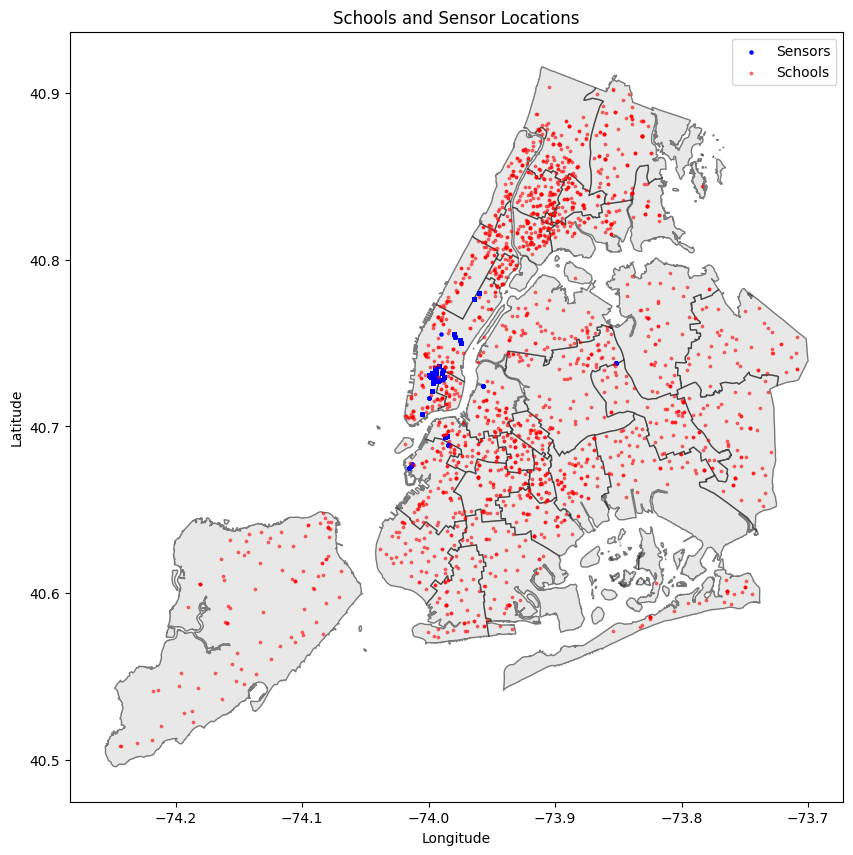

In [39]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot school districts as polygons
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot sensor locations as points
sensors_gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label="Sensors")

# Plot school locations as points
schoolpoints_gdf.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Add a title and legend
plt.title("Schools and Sensor Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Display the plot
plt.show()

There is only a small region where sensors are located on the school districts map. Let's shrink the map using a bounding box.

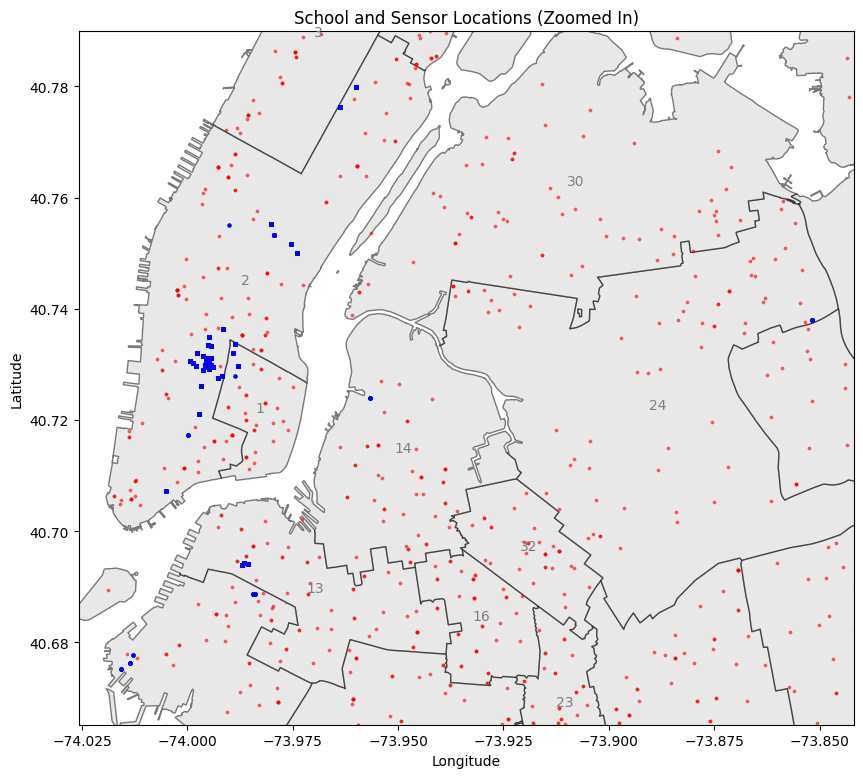

In [40]:
# Define a buffer distance (so no sensor is lying directly on the boundary of the map)
buffer_distance = 0.01

# Calculate the bounding box for the sensor data
minx, miny, maxx, maxy = sensors_gdf.total_bounds

# Expand the bounding box by the buffer distance
expanded_minx = minx - buffer_distance
expanded_miny = miny - buffer_distance
expanded_maxx = maxx + buffer_distance
expanded_maxy = maxy + buffer_distance

# Plot school districts and sensor points within the bounding box
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the school districts
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot the sensor locations
sensors_gdf.plot(ax=ax, marker='o', color='blue', markersize=5)

# Plot school locations as points
schoolpoints_gdf.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Set the plot limits to the bounding box
ax.set_xlim(expanded_minx, expanded_maxx)
ax.set_ylim(expanded_miny, expanded_maxy)

# Add district names as labels
for idx, row in districts_gdf.iterrows():
    # Calculate the centroid of the district for labeling
    centroid = row.geometry.centroid
    ax.annotate(row['school_dis'],
                xy=(centroid.x, centroid.y),
                horizontalalignment='center',
                fontsize=10,
                color='gray')

# Add title and labels
plt.title("School and Sensor Locations (Zoomed In)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

There are a number of schools that are not near our sensors that we can eliminate from our analysis.

In our analysis, we will only include schools that are within a 2 km radius of each sensor. We will create a map to visualize this:

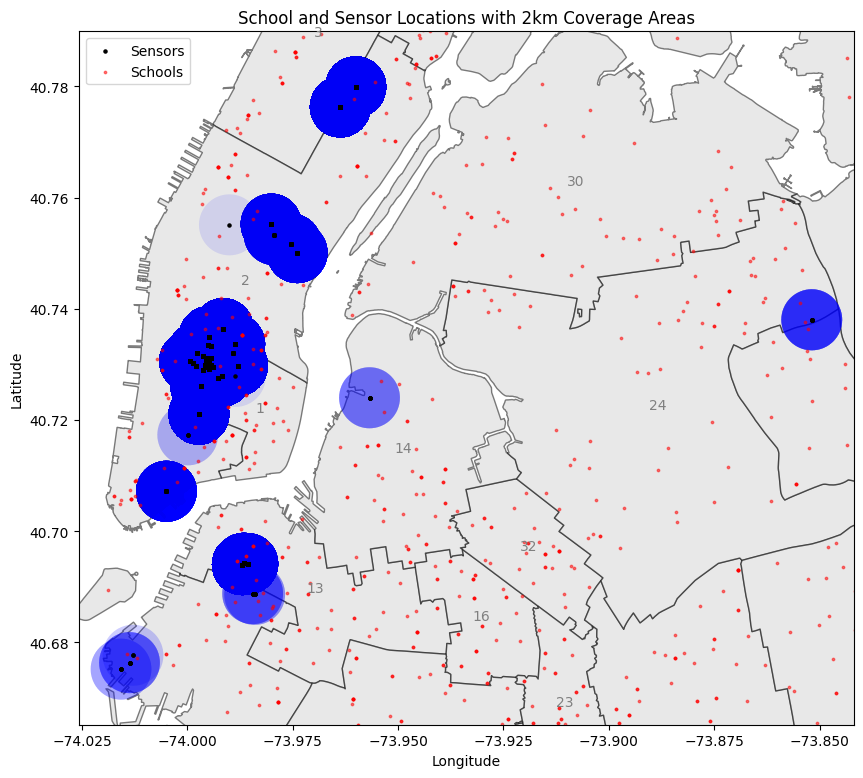

Number of schools within 2km of sensors: 72
Total number of schools: 1950
Percentage of schools covered: 3.7%


In [41]:
# Define a buffer distance
buffer_distance = 0.01

# Calculate the bounding box for the sensor data
minx, miny, maxx, maxy = sensors_gdf.total_bounds

# Expand the bounding box by the buffer distance
expanded_minx = minx - buffer_distance
expanded_miny = miny - buffer_distance
expanded_maxx = maxx + buffer_distance
expanded_maxy = maxy + buffer_distance

# Project to a local coordinate system (New York State Plane)
sensors_projected = sensors_gdf.to_crs(epsg=2263)
districts_projected = districts_gdf.to_crs(epsg=2263)
schoolpoints_projected = schoolpoints_gdf.to_crs(epsg=2263)

# Create 2km buffers around sensor points (2000 meters = 2km)
buffer_gdf = gpd.GeoDataFrame(geometry=sensors_projected.geometry.buffer(2000))
# Project buffers back to WGS 84 for plotting
buffer_gdf = buffer_gdf.set_crs(sensors_projected.crs).to_crs(sensors_gdf.crs)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the school districts
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot the buffer zones
buffer_gdf.plot(ax=ax, color='blue', alpha=0.1)

# Plot the sensor locations
sensors_gdf.plot(ax=ax, marker='o', color='black', markersize=5, label="Sensors")

# Plot school locations as points
schoolpoints_gdf.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Set the plot limits to the bounding box
ax.set_xlim(expanded_minx, expanded_maxx)
ax.set_ylim(expanded_miny, expanded_maxy)

# Add district names as labels
for idx, row in districts_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(row['school_dis'],
                xy=(centroid.x, centroid.y),
                horizontalalignment='center',
                fontsize=10,
                color='gray')

# Add title and labels
plt.title("School and Sensor Locations with 2km Coverage Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Count schools within buffer zones using projected coordinates for accuracy
schools_within_buffer = []
for buffer in sensors_projected.geometry.buffer(2000):
    schools_in_range = schoolpoints_projected[schoolpoints_projected.geometry.within(buffer)]
    schools_within_buffer.extend(schools_in_range.index.tolist())

# Get unique schools
unique_schools_covered = len(set(schools_within_buffer))
total_schools = len(schoolpoints_gdf)

print(f"Number of schools within 2km of sensors: {unique_schools_covered}")
print(f"Total number of schools: {total_schools}")
print(f"Percentage of schools covered: {(unique_schools_covered/total_schools)*100:.1f}%")

### Find closest schools to each sensor <a name="closest-schools"></a>

Let's identify all schools within a 2 km radius of each sensor.

For each sensor, we will identify all schools within a 2 km radius of that sensor. Then, we will use this list of schools to create a dataframe in which all sensor IDs are one-hot encoded. This will allow us to identify which specific schools are covered by which specific sensors. 

We will later use this information to pull annotations on sound recordings for each school.

In [42]:
# First, project the data
sensors_projected = sensors_gdf.to_crs(epsg=2263)
schoolpoints_projected = schoolpoints_gdf.to_crs(epsg=2263)

# Get unique sensor locations
unique_sensors = sensors_projected.groupby('sensor_id').agg({
    'geometry': 'first'
}).reset_index()

matches = []

# For each unique sensor
for _, sensor_row in unique_sensors.iterrows():
    # Create 2km buffer (2000 meters)
    sensor_buffer = sensor_row.geometry.buffer(2000)
    
    # Find schools within buffer
    schools_in_range = schoolpoints_projected[schoolpoints_projected.geometry.within(sensor_buffer)]
    
    # If any schools are found, add them to our matches list
    if not schools_in_range.empty:
        # Convert sensor point back to original CRS for lat/lon
        sensor_point = gpd.GeoSeries([sensor_row.geometry], crs=sensors_projected.crs).to_crs(sensors_gdf.crs)[0]
        
        for _, school in schools_in_range.iterrows():
            # Calculate distance in meters, then convert to km
            distance = sensor_row.geometry.distance(school.geometry) / 1000
            matches.append({
                'sensor_id': sensor_row['sensor_id'],
                'sensor_lat': sensor_point.y,
                'sensor_lon': sensor_point.x,
                'school_ats': school['ATS'],
                'school_name': school['Name'],
                'school_lat': school['Latitude'],
                'school_lon': school['Longitude'],
                'distance_km': distance
            })

# Create DataFrame from matches
coverage_df = pd.DataFrame(matches)

# Print some diagnostics
print(f"Number of unique sensors: {len(unique_sensors)}")
print(f"Number of unique schools in matches: {len(coverage_df['school_name'].unique())}")
print(f"Distance range: {coverage_df['distance_km'].min():.2f}km to {coverage_df['distance_km'].max():.2f}km")

# Create schools_multiple_sensors with the same process as before
schools_multiple_sensors = (
    coverage_df.groupby(['school_name', 'school_ats'])
    .agg({
        'sensor_id': ['count', list],
        'distance_km': ['min', 'max']
    })
    .reset_index()
)
schools_multiple_sensors.columns = ['school_name', 'school_ats', 'num_sensors', 'sensor_ids', 'min_distance_km', 'max_distance_km']
schools_multiple_sensors = schools_multiple_sensors.sort_values('num_sensors', ascending=False)

# Print more diagnostics
print(f"\nNumber of schools in coverage matrix: {len(schools_multiple_sensors)}")

# Let's also look at the distribution of schools per sensor
sensor_school_counts = coverage_df.groupby('sensor_id')['school_name'].nunique()
print("\nDistribution of schools per sensor:")
print(sensor_school_counts.describe())

Number of unique sensors: 54
Number of unique schools in matches: 72
Distance range: 0.34km to 2.00km

Number of schools in coverage matrix: 72

Distribution of schools per sensor:
count    52.000000
mean      4.096154
std       3.459908
min       1.000000
25%       2.000000
50%       2.500000
75%       5.250000
max      14.000000
Name: school_name, dtype: float64


In [43]:
# First get the number of recordings per sensor
recordings_per_sensor = sensors_gdf.groupby('sensor_id').size()

def create_sensor_coverage_matrix(schools_df):
    # Get all unique sensor IDs
    all_sensors = set()
    for sensor_list in schools_df['sensor_ids']:
        all_sensors.update(sensor_list)
    
    # Create a dictionary to store the binary coverage data
    coverage_dict = {
        'school_name': [],
        'school_ats': [],
        'num_sensors': [],
        'num_recordings': [],  # New column
        'min_distance_km': [],
        'max_distance_km': []
    }
    # Add a column for each sensor
    for sensor in all_sensors:
        coverage_dict[f'sensor_{sensor}'] = []
    
    # Fill the dictionary
    for _, row in schools_df.iterrows():
        coverage_dict['school_name'].append(row['school_name'])
        coverage_dict['school_ats'].append(row['school_ats'])
        coverage_dict['num_sensors'].append(row['num_sensors'])
        coverage_dict['min_distance_km'].append(row['min_distance_km'])
        coverage_dict['max_distance_km'].append(row['max_distance_km'])
        
        # Calculate total recordings for this school
        total_recordings = sum(recordings_per_sensor[sensor] for sensor in row['sensor_ids'])
        coverage_dict['num_recordings'].append(total_recordings)
        
        # Fill sensor columns
        for sensor in all_sensors:
            coverage_dict[f'sensor_{sensor}'].append(1 if sensor in row['sensor_ids'] else 0)
    
    # Create DataFrame
    coverage_matrix = pd.DataFrame(coverage_dict)
    # Set school_name as index
    coverage_matrix.set_index('school_name', inplace=True)
    
    return coverage_matrix

# Create the coverage matrix
coverage_matrix = create_sensor_coverage_matrix(schools_multiple_sensors)

# Sort columns for better readability
sensor_cols = [col for col in coverage_matrix.columns if col.startswith('sensor_')]
other_cols = [col for col in coverage_matrix.columns if not col.startswith('sensor_')]
coverage_matrix = coverage_matrix[other_cols + sorted(sensor_cols)]

### Map of schools within coverage area <a name="coverage-map"></a>
As we saw earlier, there are a number of schools that will not be covered by our analysis because they are not located close enough to a sensor. Let's create a new map with *only* the schools that will be covered by our analysis. Again, these are schools that are located within 2 km of a sensor.

In [44]:
# Create list of schools from our coverage matrix
coverage_schools = coverage_matrix['school_ats'].unique()

# Use this list to filter our schoolpoints_gdf
schoolpoints_gdf_coverage = schoolpoints_gdf[schoolpoints_gdf['ATS'].isin(coverage_schools)]

In [45]:
# Project to a local coordinate system (New York State Plane)
sensors_projected = sensors_gdf.to_crs(epsg=2263)
schoolpoints_projected = schoolpoints_gdf.to_crs(epsg=2263)

# First, let's get unique sensor locations by sensor_id
unique_sensors = sensors_projected.groupby('sensor_id').agg({
    'geometry': 'first'  # Take the first location for each sensor
}).reset_index()

# Create a list to store all matches
matches = []

# For each unique sensor
for _, sensor_row in unique_sensors.iterrows():
    # Create 2km buffer (2000 meters)
    sensor_buffer = sensor_row.geometry.buffer(2000)
    
    # Find schools within buffer
    schools_in_range = schoolpoints_projected[schoolpoints_projected.geometry.within(sensor_buffer)]
    
    # If any schools are found, add them to our matches list
    if not schools_in_range.empty:
        # Convert back to original CRS for lat/lon
        sensor_point = gpd.GeoSeries([sensor_row.geometry], crs=sensors_projected.crs).to_crs(sensors_gdf.crs)[0]
        
        for _, school in schools_in_range.iterrows():
            # Calculate distance in meters, then convert to km
            distance = sensor_row.geometry.distance(school.geometry) / 1000
            matches.append({
                'sensor_id': sensor_row['sensor_id'],
                'sensor_lat': sensor_point.y,
                'sensor_lon': sensor_point.x,
                'school_ats': school['ATS'],
                'school_name': school['Name'],
                'school_lat': school['Latitude'],
                'school_lon': school['Longitude'],
                'distance_km': distance
            })

# Create DataFrame from matches
coverage_df = pd.DataFrame(matches)

# Sort by sensor_id and distance
coverage_df = coverage_df.sort_values(['sensor_id', 'distance_km'])

# Print summary statistics
print(f"Total number of unique sensor-school pairs within 2km: {len(coverage_df)}")
print(f"Number of unique sensors: {len(unique_sensors)}")
print(f"Total number of recordings: {len(sensors_gdf)}")
print(f"Number of unique schools: {len(coverage_df['school_name'].unique())}")

print(f"\nNumber of schools covered by each sensor:")
sensor_coverage = coverage_df.groupby('sensor_id').size().sort_values(ascending=False)
print(sensor_coverage)

print(f"\nNumber of sensors covering each school:")
school_coverage = coverage_df.groupby(['school_name', 'school_ats']).size().sort_values(ascending=False)
print(school_coverage)

# Create a summary DataFrame showing schools with multiple sensors
schools_multiple_sensors = (
    coverage_df.groupby(['school_name', 'school_ats'])
    .agg({
        'sensor_id': ['count', list],
        'distance_km': ['min', 'max']
    })
    .reset_index()
)
schools_multiple_sensors.columns = ['school_name', 'school_ats', 'num_sensors', 'sensor_ids', 'min_distance_km', 'max_distance_km']
schools_multiple_sensors = schools_multiple_sensors.sort_values('num_sensors', ascending=False)

print("\nSchools covered by multiple sensors:")
print(schools_multiple_sensors[schools_multiple_sensors['num_sensors'] > 1])

# Additional information about recordings per sensor
recordings_per_sensor = sensors_gdf.groupby('sensor_id').size().sort_values(ascending=False)
print("\nNumber of recordings per sensor:")
print(recordings_per_sensor)

# Let's also verify the distance calculations
print("\nDistance statistics (km):")
print(coverage_df['distance_km'].describe())

Total number of unique sensor-school pairs within 2km: 213
Number of unique sensors: 54
Total number of recordings: 17983
Number of unique schools: 72

Number of schools covered by each sensor:
sensor_id
46    14
8     13
6     11
14    10
49    10
50     9
5      9
36     9
13     9
56     8
15     7
57     7
51     6
16     5
41     5
32     5
38     4
11     4
19     4
24     4
3      4
34     4
10     3
45     3
1      3
29     3
48     2
35     2
33     2
61     2
31     2
30     2
26     2
23     2
53     2
17     2
55     2
4      2
2      2
52     2
0      1
40     1
39     1
37     1
25     1
22     1
20     1
18     1
12     1
9      1
7      1
27     1
dtype: int64

Number of sensors covering each school:
school_name                                       school_ats
Harvey Milk High School                           02M586        28
Great Oaks Charter School                         84M202        10
P.S. 041 Greenwich Village                        02M041         9
Harvest Coll

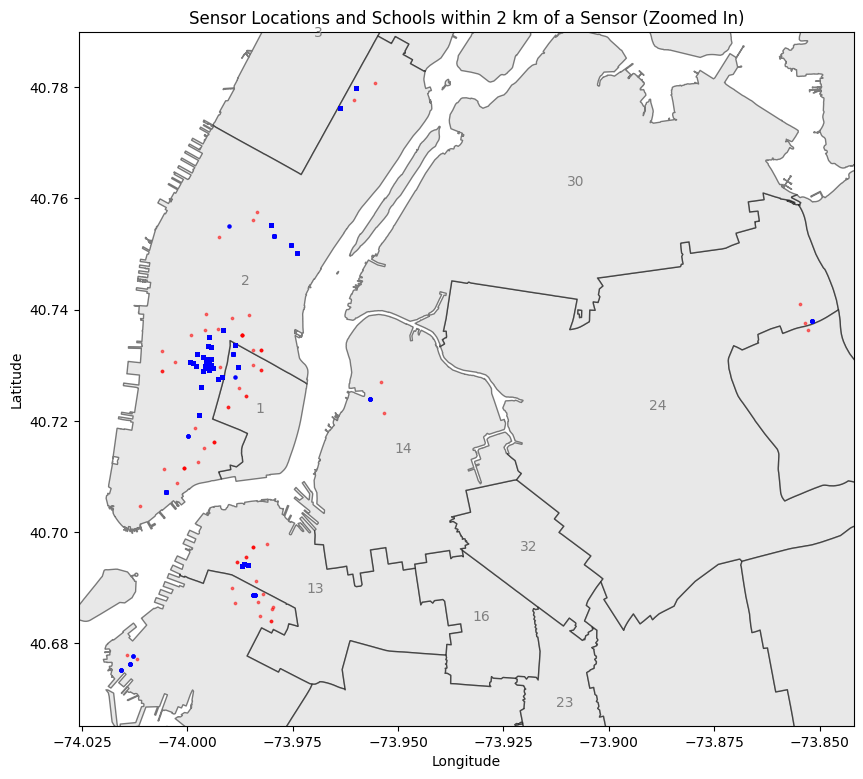

In [46]:
# Define a buffer distance (so no sensor is lying directly on the boundary of the map)
buffer_distance = 0.01

# Calculate the bounding box for the sensor data
minx, miny, maxx, maxy = sensors_gdf.total_bounds

# Expand the bounding box by the buffer distance
expanded_minx = minx - buffer_distance
expanded_miny = miny - buffer_distance
expanded_maxx = maxx + buffer_distance
expanded_maxy = maxy + buffer_distance

# Plot school districts and sensor points within the bounding box
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the school districts
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot the sensor locations
sensors_gdf.plot(ax=ax, marker='o', color='blue', markersize=5)

# Plot school locations as points
schoolpoints_gdf_coverage.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Set the plot limits to the bounding box
ax.set_xlim(expanded_minx, expanded_maxx)
ax.set_ylim(expanded_miny, expanded_maxy)

# Add district names as labels
for idx, row in districts_gdf.iterrows():
    # Calculate the centroid of the district for labeling
    centroid = row.geometry.centroid
    ax.annotate(row['school_dis'],
                xy=(centroid.x, centroid.y),
                horizontalalignment='center',
                fontsize=10,
                color='gray')

# Add title and labels
plt.title("Sensor Locations and Schools within 2 km of a Sensor (Zoomed In)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

---

## School quality reports <a name="school-quality"></a>
School quality reports are freely available on the New York City Public Schools website. Source page is [here](https://infohub.nyced.org/reports/students-and-schools/school-quality/school-quality-reports-and-resources/school-quality-report-citywide-data).

We have school quality reports from elementary, middle, and high schools for the academic years 2016-2017 through 2018-2019. Each school year is comprised of two separate reports, both in Excel format: one containing elementary and middle school quality metrics, and another containing high school quality metrics.

### Load school quality reports <a name="load-quality-data"></a>
We will load the school quality reports into their own `ExcelFile` objects.

In [47]:
# 2016-2017 school year
lower_grades_16_17 = pd.ExcelFile('./School Quality Reports/201617_ems_sqr.xlsx')
high_school_16_17 = pd.ExcelFile('./School Quality Reports/201617_hs_sqr.xlsx')

# 2017-2018 school year
lower_grades_17_18 = pd.ExcelFile('./School Quality Reports/201718_ems_sqr.xlsx')
high_school_17_18 = pd.ExcelFile('./School Quality Reports/201718_hs_sqr.xlsx')

# 2018-2019 school year
lower_grades_18_19 = pd.ExcelFile('./School Quality Reports/201718_ems_sqr.xlsx')
high_school_18_19 = pd.ExcelFile('./School Quality Reports/201718_hs_sqr.xlsx')

Using these `ExcelFile` objects, we will retrieve the sheets `"Summary"` and `"Student Achievement"` from each Excel file and load each into a dictionary, `summary_sheets` and `achievement_sheets` respectively.

In both of these steps, we will use a list of school IDs to filter the sheets. Let's create this list here:

In [48]:
# Get the list of school IDs to filter on
school_ids = coverage_matrix['school_ats'].unique()

#### Summary sheets

Let's parse the `"Summary"` sheets from each Excel workbook loaded in the previous step.

In [49]:
lg_reports = [lower_grades_16_17, lower_grades_17_18, lower_grades_18_19] 
hs_reports = [high_school_16_17, high_school_17_18, high_school_18_19]

summary_sheets = {}

# Parsing for K-8 (lower grades) reports
for idx, report in enumerate(lg_reports):
    df = report.parse('Summary')
    
    # Assign the first row as the header and drop it from the DataFrame
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    
    # Store the processed DataFrame in a dictionary
    summary_sheets[f'lg_summary_{16+idx}_{17+idx}'] = df

# Parsing for high school reports
for idx, report in enumerate(hs_reports):
    df = report.parse('Summary')
    
    # Assign the first row as the header and drop it from the DataFrame
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    
    # Store the processed DataFrame in a dictionary
    summary_sheets[f'hs_summary_{16+idx}_{17+idx}'] = df

Now, let's filter the `DBN` column to include schools from our `coverage_matrix`.

In [50]:
# Loop through each achievement sheet DataFrame in the dictionary and filter it
coverage_summary_sheets = {}
for key, df in summary_sheets.items():
    # Filter the DataFrame to only include rows where DBN is in school_ids
    coverage_summary_sheets[key] = df[df['DBN'].isin(school_ids)].reset_index(drop=True)

In [51]:
# Do the same for schools that are not in our coverage area
non_coverage_summary_sheets = {}
for key, df in summary_sheets.items():
    non_coverage_summary_sheets[key] = df[~df['DBN'].isin(school_ids)].reset_index(drop=True)

Let's define a dictionary in which we name the features we are interested in including as keys. As values, we will write the new name for the column in the dataframe we will create.

In [52]:
# Define column mapping dictionary for summary metrics (old_name: new_name)
summary_columns = {
    # School identifiers
    'DBN': 'DBN',
    'School Name': 'school_name',
    
    # Enrollment
    'Enrollment': 'enrollment',
    
    # Student population characteristics
    'Percent English Language Learners': 'ell_pct',
    'Percent Students with Disabilities': 'disability_pct',
    'Percent Self-Contained': 'self_contained_pct',
    
    # Demographics
    'Percent Asian': 'asian_pct',
    'Percent Black': 'black_pct',
    'Percent Hispanic': 'hispanic_pct',
    'Percent White': 'white_pct',
    
    # Attendance metrics
    'Student Attendance Rate': 'student_attendance_rate',
    'Percent of Students Chronically Absent': 'chronic_absence_pct',
    'Teacher Attendance Rate': 'teacher_attendance_rate'
}

Now, let's use this list to loop through our `coverage_summary_sheets` and `non_coverage_summary_sheets` dictionaries to create new dataframes that include only the features we are interested in.

In this section, we will also define a function `convert_datatypes` to be used in our loop, which will convert columns to the appropriate datatype as we go.

In [53]:
def convert_datatypes(df, dtype_dict):
    """
    Convert column data types according to specified dictionary
    Handles percentage strings, currency strings, etc.
    """
    df = df.copy()  # Create copy to avoid modifying original
    
    for col, dtype in dtype_dict.items():
        if col in df.columns:
            try:
                if dtype in ['float64', 'int64']:
                    # Remove percentage signs and convert to numeric if present
                    if df[col].dtype == 'object':
                        # Updated string replacement to avoid deprecation warning
                        df[col] = df[col].astype(str).str.replace('%', '')
                        df[col] = df[col].astype(str).str.replace('$', '')
                        df[col] = df[col].astype(str).str.replace(',', '')
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    if dtype == 'int64':
                        df[col] = df[col].astype('int64', errors='ignore')
                
                elif dtype == 'string':
                    df[col] = df[col].astype('string')
                
                elif dtype == 'boolean':
                    df[col] = df[col].astype('boolean')
                
            except Exception as e:
                print(f"Error converting {col} to {dtype}: {str(e)}")
    
    return df

In [54]:
# Define dictionary for column data types
dtype_conversions = {
    'enrollment':'int64',
    'ell_pct':'float64',
    'disability_pct':'float64',
    'self_contained_pct':'float64',
    'asian_pct':'float64',
    'black_pct':'float64',
    'hispanic_pct':'float64',
    'white_pct':'float64',
    'student_attendance_rate':'float64',
    'chronic_absence_pct':'float64',
    'teacher_attendance_rate':'float64'
}

##### Coverage schools

In [55]:
coverage_summary_dfs = []

# Loop through the dictionary keys
for sheet_name, df in coverage_summary_sheets.items():
    # Extract the academic year from the sheet name
    academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
    
    # Select and rename columns in one step
    temp_df = df[summary_columns.keys()].rename(columns=summary_columns)
    
    # Convert data types
    temp_df = convert_datatypes(temp_df, dtype_conversions)
    
    # Add academic year column
    temp_df['academic_year'] = academic_year
    
    # Add coverage column
    temp_df['coverage'] = True
    
    # Add grade level column
    temp_df['grade_level'] = 'lg' if 'lg' in sheet_name else 'hs'
    
    # Append to our list
    coverage_summary_dfs.append(temp_df)

# Combine all dataframes
coverage_combined_summary_df = pd.concat(coverage_summary_dfs, ignore_index=True)
coverage_combined_summary_df = coverage_combined_summary_df.sort_values(['academic_year', 'DBN'])

# Verify the conversions worked
print("\nFinal data types:")
print(coverage_combined_summary_df.dtypes)

# Display info about the combined dataset
print(f"Total number of records: {len(coverage_combined_summary_df)}")
print(f"\nAcademic years included: {coverage_combined_summary_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {coverage_combined_summary_df['DBN'].nunique()}")

# Additional validation to check grade level assignment
print("\nDistribution by grade level:")
print(coverage_combined_summary_df['grade_level'].value_counts())

# Check for schools that appear in both grade levels
print("\nChecking for schools in both grade levels:")
temp_schools_both_levels = coverage_combined_summary_df.groupby('DBN')['grade_level'].nunique()
print(f"Schools with both grade levels: {len(temp_schools_both_levels[temp_schools_both_levels > 1])}")

# Start a list schools_both_levels to keep track of schools that are K-12
schools_both_levels = temp_schools_both_levels[temp_schools_both_levels > 1]


Final data types:
0
DBN                         object
school_name                 object
enrollment                   int64
ell_pct                    float64
disability_pct             float64
self_contained_pct         float64
asian_pct                  float64
black_pct                  float64
hispanic_pct               float64
white_pct                  float64
student_attendance_rate    float64
chronic_absence_pct        float64
teacher_attendance_rate    float64
academic_year               object
coverage                      bool
grade_level                 object
dtype: object
Total number of records: 177

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 54

Distribution by grade level:
grade_level
hs    90
lg    87
Name: count, dtype: int64

Checking for schools in both grade levels:
Schools with both grade levels: 5


Something too keep in mind during our data analysis is that there are schools whose DBNs belong to both the lower grades and the high school grades. These schools include grades K-12 and are in the list `schools_both_levels`.

##### Non-coverage schools

In [56]:
non_coverage_summary_dfs = []

# Loop through the dictionary keys
for sheet_name, df in non_coverage_summary_sheets.items():
    # Extract the academic year from the sheet name
    academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
    
    # Select and rename columns in one step
    temp_df = df[summary_columns.keys()].rename(columns=summary_columns)
    
    # Convert data types
    temp_df = convert_datatypes(temp_df, dtype_conversions)
    
    # Add academic year column
    temp_df['academic_year'] = academic_year
    
    # Add coverage column
    temp_df['coverage'] = False
    
    # Add grade level column
    temp_df['grade_level'] = 'lg' if 'lg' in sheet_name else 'hs'
    
    # Append to our list
    non_coverage_summary_dfs.append(temp_df)

# Combine all dataframes
non_coverage_combined_summary_df = pd.concat(non_coverage_summary_dfs, ignore_index=True)
non_coverage_combined_summary_df = non_coverage_combined_summary_df.sort_values(['academic_year', 'DBN'])

# Verify the conversions worked
print("\nFinal data types:")
print(non_coverage_combined_summary_df.dtypes)

# Display info about the combined dataset
print(f"Total number of records: {len(non_coverage_combined_summary_df)}")
print(f"\nAcademic years included: {non_coverage_combined_summary_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {non_coverage_combined_summary_df['DBN'].nunique()}")

# Additional validation to check grade level assignment
print("\nDistribution by grade level:")
print(non_coverage_combined_summary_df['grade_level'].value_counts())

# Check for schools that appear in both grade levels
print("\nChecking for schools in both grade levels:")
temp_schools_both_levels = non_coverage_combined_summary_df.groupby('DBN')['grade_level'].nunique()
print(f"Schools with both grade levels: {len(temp_schools_both_levels[temp_schools_both_levels > 1])}")

# Append temp_schools_both_levels to schools_both_levels
schools_both_levels = pd.concat([schools_both_levels, temp_schools_both_levels[temp_schools_both_levels > 1]])

# Convert schools_both_levels to a list
schools_both_levels = list(schools_both_levels.index)


Final data types:
0
DBN                         object
school_name                 object
enrollment                   int64
ell_pct                    float64
disability_pct             float64
self_contained_pct         float64
asian_pct                  float64
black_pct                  float64
hispanic_pct               float64
white_pct                  float64
student_attendance_rate    float64
chronic_absence_pct        float64
teacher_attendance_rate    float64
academic_year               object
coverage                      bool
grade_level                 object
dtype: object
Total number of records: 5127

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 1609

Distribution by grade level:
grade_level
lg    3754
hs    1373
Name: count, dtype: int64

Checking for schools in both grade levels:
Schools with both grade levels: 124


##### Check missing schools (Summary sheets)
Based on the number of unique schools in our `coverage_combined_summary_df` dataframe, it looks like we might be missing some data, since the length of our `school_ids` list is `72`. While we won't delve too deep into this discrepancy at this stage in data cleaning, let's keep this in mind during our data exploration phase. For now, let's create a list of missing schools.

In [57]:
# Get list of unique schools from combined_summary_df
summary_schools = coverage_combined_summary_df['DBN'].unique()

# Convert both lists to sets for easier comparison
school_ids_set = set(school_ids)
summary_schools_set = set(summary_schools)

# Find schools that are in school_ids but not in summary_schools
missing_summary_schools = school_ids_set - summary_schools_set

# Print results
print(f"Total schools in school_ids: {len(school_ids)}")
print(f"Total schools in summary_df: {len(summary_schools)}")
print(f"\nNumber of missing schools: {len(missing_summary_schools)}")
print("\nMissing schools:")
for school in sorted(missing_summary_schools):
    print(school)

Total schools in school_ids: 72
Total schools in summary_df: 54

Number of missing schools: 18

Missing schools:
01M458
01M650
02M340
02M394
02M560
02M575
02M586
13K482
15K423
15K456
15K698
75K369
75M169
75M226
75M721
75M751
79M984
84K937


##### Combine summary dataframes into one

In [58]:
# Append coverage_combined_summary_df to non_coverage_combined_summary_df
combined_summary_df = pd.concat([non_coverage_combined_summary_df, coverage_combined_summary_df], ignore_index=True)

#### Achievement sheets

In [59]:
# Parsing for achievement_sheets

achievement_sheets = {}

# Parsing for K-8 (lower grades) reports
for idx, report in enumerate(lg_reports):
    df = report.parse('Student Achievement')
    
    # Assign the first row as the header and drop it from the DataFrame
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    
    # Store the processed DataFrame in a dictionary
    achievement_sheets[f'lg_achievement_{16+idx}_{17+idx}'] = df

# Parsing for high school reports
for idx, report in enumerate(hs_reports):
    df = report.parse('Student Achievement')
    
    # Assign the first row as the header and drop it from the DataFrame
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    
    # Store the processed DataFrame in a dictionary
    achievement_sheets[f'hs_achievement_{16+idx}_{17+idx}'] = df

Just as we did for `summary_sheets`, let's filter `achievement_sheets` for schools that are in our `coverage_matrix` on `DBN`:

In [60]:
# Loop through each achievement sheet DataFrame in the dictionary and filter it
coverage_achievement_sheets = {}
non_coverage_achievement_sheets = {}
for key, df in achievement_sheets.items():
    # Filter the DataFrame to only include rows where DBN is in school_ids
    coverage_achievement_sheets[key] = df[df['DBN'].isin(school_ids)].reset_index(drop=True)
    # Do the same for schools that are not in our coverage area
    non_coverage_achievement_sheets[key] = df[~df['DBN'].isin(school_ids)].reset_index(drop=True)

Just as we did for the "Summary" portion of this section, let's define which features from the "Student Achievement" sheet we are interested in.

Note that these metrics differ between lower grades (elementary and middle schools) and high schools, so we will be handling them separately.

##### Elementary and middle schools

In [61]:
# Define column mapping dictionary (old_name: new_name)
achievement_columns = {
    # School identifiers (keep original names)
    'DBN': 'DBN',
    'School Name': 'school_name',
    'School Type': 'school_type',
    
    # Overall achievement rating
    'Student Achievement - Section Rating': 'achievement_rating',
    'Student Achievement - Section Score': 'achievement_score',
    
    # ELA Proficiency metrics
    'Metric Value - Percentage of Students at Level 3 or 4, ELA': 'ela_proficient_pct',
    'Metric Value - Average Student Proficiency, ELA': 'ela_avg_proficiency',
    'Metric Value - Average Student Proficiency, ELA, School\'s Lowest Third': 'ela_lowest_third_proficiency',
    
    # Math Proficiency metrics
    'Metric Value - Percentage of Students at Level 3 or 4, Math': 'math_proficient_pct',
    'Metric Value - Average Student Proficiency, Math': 'math_avg_proficiency',
    'Metric Value - Average Student Proficiency, Math, School\'s Lowest Third': 'math_lowest_third_proficiency',
    
    # Attendance
    'Percentage of Students with 90%+ Attendance': 'attendance_90_plus_pct',
    
    # Sample size indicators
    'N count - Percentage of Students at Level 3 or 4, ELA': 'ela_proficient_n',
    'N count - Percentage of Students at Level 3 or 4, Math': 'math_proficient_n',
    'N count - Average Student Proficiency, ELA, School\'s Lowest Third': 'ela_lowest_third_n',
    'N count - Average Student Proficiency, Math, School\'s Lowest Third': 'math_lowest_third_n'
}

Now, let's use this dictionary to create new dataframes. Then, we will combine these dataframes into one large dataframe containing the elementary and middle school data called `lg_achievement_df`.

In [62]:
lg_achievement_dtype_conversions = {
    'achievement_score': 'float64',
    'ela_proficient_pct': 'float64',
    'ela_avg_proficiency': 'float64',
    'ela_lowest_third_proficiency': 'float64',
    'math_proficient_pct': 'float64',
    'math_avg_proficiency': 'float64',
    'math_lowest_third_proficiency': 'float64',
    'attendance_90_plus_pct': 'float64',
    'ela_proficient_n': 'int64',
    'math_proficient_n': 'int64',
    'ela_lowest_third_n': 'int64',
    'math_lowest_third_n': 'int64'
}

In [63]:
# For COVERAGE SCHOOLS

coverage_lg_achievement_dfs = []

# Loop through the dictionary keys
for sheet_name, df in coverage_achievement_sheets.items():
    # Check if this is a lower grades achievement sheet
    if 'lg_achievement_' in sheet_name:
        # Extract the academic year from the sheet name
        academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
        
        # Select and rename columns
        temp_df = df[achievement_columns.keys()].rename(columns=achievement_columns)
        
        # Convert data types
        temp_df = convert_datatypes(temp_df, lg_achievement_dtype_conversions)
        
        # Add academic year column
        temp_df['academic_year'] = academic_year
        
        # Add coverage column
        temp_df['coverage'] = True
        
        # Add grade_level column
        temp_df['grade_level'] = 'lg'
        
        # Append to our list
        coverage_lg_achievement_dfs.append(temp_df)

# Create a dataframe of just the lower grades school data
coverage_lg_achievement_df = pd.concat(coverage_lg_achievement_dfs, ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(coverage_lg_achievement_df)}")
print(f"\nAcademic years included: {coverage_lg_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {coverage_lg_achievement_df['DBN'].nunique()}")

Total number of records: 87

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 29


In [64]:
# Verify the data types
print("Final data types for lower grades achievement data:")
print(coverage_lg_achievement_df.dtypes)

Final data types for lower grades achievement data:
0
DBN                               object
school_name                       object
school_type                       object
achievement_rating                object
achievement_score                float64
ela_proficient_pct               float64
ela_avg_proficiency              float64
ela_lowest_third_proficiency     float64
math_proficient_pct              float64
math_avg_proficiency             float64
math_lowest_third_proficiency    float64
attendance_90_plus_pct           float64
ela_proficient_n                   int64
math_proficient_n                  int64
ela_lowest_third_n                 int64
math_lowest_third_n                int64
academic_year                     object
coverage                            bool
grade_level                       object
dtype: object


In [65]:
# For NON-COVERAGE SCHOOLS

non_coverage_achievement_dfs = []

# Loop through the dictionary keys
for sheet_name, df in non_coverage_achievement_sheets.items():
    # Check if this is a lower grades achievement sheet
    if 'lg_achievement_' in sheet_name:
        # Extract the academic year from the sheet name
        academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
        
        # Select and rename columns
        temp_df = df[achievement_columns.keys()].rename(columns=achievement_columns)
        
        # Convert data types
        temp_df = convert_datatypes(temp_df, lg_achievement_dtype_conversions)
        
        # Add academic year column
        temp_df['academic_year'] = academic_year
        
        # Add coverage column
        temp_df['coverage'] = False
        
        # Add grade_level column
        temp_df['grade_level'] = 'lg'
        
        # Append to our list
        non_coverage_achievement_dfs.append(temp_df)

# Create a dataframe of just the lower grades school data
non_coverage_lg_achievement_df = pd.concat(non_coverage_achievement_dfs, ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(non_coverage_lg_achievement_df)}")
print(f"\nAcademic years included: {non_coverage_lg_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {non_coverage_lg_achievement_df['DBN'].nunique()}")

Total number of records: 3754

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 1267


In [66]:
# Verify the data types
print("Final data types for lower grades achievement data:")
print(non_coverage_lg_achievement_df.dtypes)

Final data types for lower grades achievement data:
0
DBN                               object
school_name                       object
school_type                       object
achievement_rating                object
achievement_score                float64
ela_proficient_pct               float64
ela_avg_proficiency              float64
ela_lowest_third_proficiency     float64
math_proficient_pct              float64
math_avg_proficiency             float64
math_lowest_third_proficiency    float64
attendance_90_plus_pct           float64
ela_proficient_n                   int64
math_proficient_n                  int64
ela_lowest_third_n                 int64
math_lowest_third_n                int64
academic_year                     object
coverage                            bool
grade_level                       object
dtype: object


##### Combine lower-grades achievement dataframes into one

In [67]:
# Append coverage_lg_achievement_df to non_coverage_lg_achievement_df
combined_lg_achievement_df = pd.concat([non_coverage_lg_achievement_df, coverage_lg_achievement_df], ignore_index=True)

While we are at it, let's use `coverage_lg_achievement_df` and `non_coverage_lg_achievement_df` to create a list of elementary and middle schools. This could be helpful in our EDA phase.

In [68]:
# Drop duplicates based on 'DBN', keeping the first occurrence
combined_lg_df = combined_lg_achievement_df.drop_duplicates(subset='DBN', keep='first')

# Filter for elementary and middle schools
elem_middle_schools = (
    combined_lg_df[['DBN', 'school_name', 'grade_level', 'coverage']]
    .sort_values('DBN')
    .reset_index(drop=True)
)

##### High school grades

In [69]:
# Define column mapping dictionary for high school metrics (old_name: new_name)
hs_achievement_columns = {
    # School identifiers (keep original names)
    'DBN': 'DBN',
    'School Name': 'school_name',
    'School Type': 'school_type',
    
    # Overall achievement rating
    'Student Achievement - Section Rating': 'achievement_rating',
    'Student Achievement - Section Score': 'achievement_score',
    
    # Graduation metrics
    'Metric Value - 4-Year Graduation Rate': 'grad_rate_4yr',
    'Metric Value - 6-Year Graduation Rate': 'grad_rate_6yr',
    
    # Core Regents exam performance
    'Metric Value - Average Regents Score - English (Common Core)': 'regents_english',
    'Metric Value - Average Regents Score - Algebra I (Common Core)': 'regents_algebra',
    'Metric Value - Average Regents Score - Living Environment': 'regents_living_env',
    'Metric Value - Average Regents Score - Global History': 'regents_global',
    'Metric Value - Average Regents Score - US History': 'regents_us_history',
    
    # College readiness
    'Metric Value - College and Career Preparatory Course Index': 'college_prep_index',
    'Metric Value - 4-Year College Readiness Index': 'college_ready_4yr',
    'Metric Value - 6-Year College Readiness Index': 'college_ready_6yr',
    
    # Post-secondary outcomes
    'Metric Value - Postsecondary Enrollment Rate - 6 Months': 'postsec_enroll_6mo',
    'Metric Value - Postsecondary Enrollment Rate - 18 Months': 'postsec_enroll_18mo',
    
    # Credit accumulation
    'Metric Value - 10+ Credits in 1st Year - All Students': 'credits_yr1',
    'Metric Value - 10+ Credits in 2nd Year - All Students': 'credits_yr2',
    'Metric Value - 10+ Credits in 3rd Year - All Students': 'credits_yr3',
    
    # Sample size indicators
    'N count - 4-Year Graduation Rate': 'grad_rate_n',
    'N count - Average Regents Score - English (Common Core)': 'regents_english_n',
    'N count - 4-Year College Readiness Index': 'college_ready_n',
    
    # Attendance
    'Percentage of Students with 90%+ Attendance': 'attendance_90_plus_pct'
}

Let's do the same for the high schools:

In [70]:
# Define data types for high school achievement metrics
hs_achievement_dtype_conversions = {
    'achievement_score': 'float64',
    'grad_rate_4yr': 'float64',
    'grad_rate_6yr': 'float64',
    'college_ready_4yr': 'float64',
    'college_ready_6yr': 'float64',
    'regents_english': 'float64',
    'regents_algebra': 'float64',
    'regents_living_env': 'float64',
    'regents_global': 'float64',
    'regents_us_history': 'float64',
    'college_prep_index': 'float64',
    'postsec_enroll_6mo': 'float64',
    'postsec_enroll_18mo': 'float64',
    'credits_yr1': 'float64',
    'credits_yr2': 'float64',
    'credits_yr3': 'float64',
    'grad_rate_n': 'int64',
    'regents_english_n': 'int64',
    'college_ready_n': 'int64',
    'attendance_90_plus_pct': 'float64'
}

In [71]:
# For COVERAGE SCHOOLS

coverage_hs_achievement_dfs = []

# Loop through the dictionary keys
for sheet_name, df in coverage_achievement_sheets.items():
    # Check if this is a high school achievement sheet
    if 'hs_achievement_' in sheet_name:
        # Extract the academic year from the sheet name
        academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
        
        # Select and rename columns in one step
        temp_df = df[hs_achievement_columns.keys()].rename(columns=hs_achievement_columns)
        
        # Convert data types
        temp_df = convert_datatypes(temp_df, hs_achievement_dtype_conversions)
        
        # Add academic year column
        temp_df['academic_year'] = academic_year

        # Add coverage column
        temp_df['coverage'] = True
        
        # Add grade_level column
        temp_df['grade_level'] = 'hs'
        
        # Append to our list
        coverage_hs_achievement_dfs.append(temp_df)

# Create a dataframe of just the high school data
coverage_hs_achievement_df = pd.concat(coverage_hs_achievement_dfs, ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(coverage_hs_achievement_df)}")
print(f"\nAcademic years included: {coverage_hs_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {coverage_hs_achievement_df['DBN'].nunique()}")

Total number of records: 90

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 30


In [72]:
# Verify the data types
print("Final data types for high school achievement data:")
print(coverage_hs_achievement_df.dtypes)

Final data types for high school achievement data:
0
DBN                        object
school_name                object
school_type                object
achievement_rating         object
achievement_score         float64
grad_rate_4yr             float64
grad_rate_6yr             float64
regents_english           float64
regents_algebra           float64
regents_living_env        float64
regents_global            float64
regents_us_history        float64
college_prep_index        float64
college_ready_4yr         float64
college_ready_6yr         float64
postsec_enroll_6mo        float64
postsec_enroll_18mo       float64
credits_yr1               float64
credits_yr2               float64
credits_yr3               float64
grad_rate_n               float64
regents_english_n           int64
college_ready_n           float64
attendance_90_plus_pct    float64
academic_year              object
coverage                     bool
grade_level                object
dtype: object


`grad_rate_n` and `college_ready_n` did not convert to `int64`, so let's investigate why.

In [73]:
for col in ['college_ready_n', 'grad_rate_n']:
    print(f"\nCurrent dtype of {col}:", coverage_hs_achievement_df[col].dtype)
    print(f"\nSample values of {col}:")
    print(coverage_hs_achievement_df[col].head())
    
    # Check for any non-numeric values
    print(f"\nUnique non-numeric values in {col}:")
    non_numeric = coverage_hs_achievement_df[pd.to_numeric(coverage_hs_achievement_df[col], errors='coerce').isna()][col]
    if len(non_numeric) > 0:
        print(non_numeric.unique())
        print(len(non_numeric))


Current dtype of college_ready_n: float64

Sample values of college_ready_n:
0    88.0
1    92.0
2     NaN
3     NaN
4     1.0
Name: college_ready_n, dtype: float64

Unique non-numeric values in college_ready_n:
[nan]
4

Current dtype of grad_rate_n: float64

Sample values of grad_rate_n:
0    88.0
1    92.0
2     NaN
3     NaN
4     1.0
Name: grad_rate_n, dtype: float64

Unique non-numeric values in grad_rate_n:
[nan]
4


It looks like these the `NaN` values in these columns are responsible for why they are not converting to integers. These `NaN` values might appear for a few reasons: perhaps the school in question has not been open long enough to have graduates, or they did not report graduation data for that year.

The number of `NaN` values is fairly low. Let's see which schools these belong to:

In [74]:
# NaN schools for college_ready_n
nan_schools = coverage_hs_achievement_df[coverage_hs_achievement_df['college_ready_n'].isna()][['DBN', 'school_name', 'academic_year', 'college_ready_n']]
nan_schools

,DBN,school_name,academic_year,college_ready_n
2,02M260,M.S. 260 Clinton School Writers & Artists,2016-2017,NaN
3,02M280,Manhattan Early College School for Advertising,2016-2017,NaN
32,02M260,M.S. 260 Clinton School Writers & Artists,2017-2018,NaN
62,02M260,M.S. 260 Clinton School Writers & Artists,2018-2019,NaN


In [75]:
# NaN schools for grad_rate_n
nan_schools = coverage_hs_achievement_df[coverage_hs_achievement_df['grad_rate_n'].isna()][['DBN', 'school_name', 'academic_year', 'grad_rate_n']]
nan_schools

,DBN,school_name,academic_year,grad_rate_n
2,02M260,M.S. 260 Clinton School Writers & Artists,2016-2017,NaN
3,02M280,Manhattan Early College School for Advertising,2016-2017,NaN
32,02M260,M.S. 260 Clinton School Writers & Artists,2017-2018,NaN
62,02M260,M.S. 260 Clinton School Writers & Artists,2018-2019,NaN


For both `college_ready_n` and `grad_rate_n`, the same schools have `NaN` values. Let's fill these values to `-1` as a way to mark them for further exploration in our EDA phase.

In [76]:
columns_to_fix = ['college_ready_n', 'grad_rate_n']

for col in columns_to_fix:
    print(f"\nProcessing {col}:")
    # First clean the data
    coverage_hs_achievement_df[col] = coverage_hs_achievement_df[col].astype(str).str.replace(',', '')
    # Convert to float first (in case there are decimal points)
    coverage_hs_achievement_df[col] = pd.to_numeric(coverage_hs_achievement_df[col], errors='coerce')
    # Then convert to integer, replacing NaN with -1 or another sentinel value
    coverage_hs_achievement_df[col] = coverage_hs_achievement_df[col].fillna(-1).astype('int64')

    # Print summary of conversion
    print(f"After conversion of {col}:")
    print("New dtype:", coverage_hs_achievement_df[col].dtype)
    print("Value range:", coverage_hs_achievement_df[col].min(), "to", coverage_hs_achievement_df[col].max())
    print("Number of -1 values (originally NaN):", (coverage_hs_achievement_df[col] == -1).sum())


Processing college_ready_n:
After conversion of college_ready_n:
New dtype: int64
Value range: -1 to 397
Number of -1 values (originally NaN): 4

Processing grad_rate_n:
After conversion of grad_rate_n:
New dtype: int64
Value range: -1 to 397
Number of -1 values (originally NaN): 4


After some manipulation, we have successfully converted the columns `college_ready_n` and `grad_rate_n` to type integer.

In [77]:
# For NON-COVERAGE SCHOOLS

non_coverage_hs_achievement_dfs = []

# Loop through the dictionary keys
for sheet_name, df in non_coverage_achievement_sheets.items():
    # Check if this is a high school achievement sheet
    if 'hs_achievement_' in sheet_name:
        # Extract the academic year from the sheet name
        academic_year = '20' + sheet_name.split('_')[-2] + '-20' + sheet_name.split('_')[-1]
        
        # Select and rename columns in one step
        temp_df = df[hs_achievement_columns.keys()].rename(columns=hs_achievement_columns)
        
        # Convert data types
        temp_df = convert_datatypes(temp_df, hs_achievement_dtype_conversions)
        
        # Add academic year column
        temp_df['academic_year'] = academic_year
        
        # Add coverage column
        temp_df['coverage'] = False
        
        # Add grade_level column
        temp_df['grade_level'] = 'hs'
        
        # Append to our list
        non_coverage_hs_achievement_dfs.append(temp_df)

# Create a dataframe of just the high school data
non_coverage_hs_achievement_df = pd.concat(non_coverage_hs_achievement_dfs, ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(non_coverage_hs_achievement_df)}")
print(f"\nAcademic years included: {non_coverage_hs_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {non_coverage_hs_achievement_df['DBN'].nunique()}")

Total number of records: 1373

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 466


Just as we did with high schools in our coverage zone, let's verify the data types of high schools outside of our coverage zone.

In [78]:
# Verify the data types
print("Final data types for high school achievement data:")
print(non_coverage_hs_achievement_df.dtypes)

Final data types for high school achievement data:
0
DBN                        object
school_name                object
school_type                object
achievement_rating         object
achievement_score         float64
grad_rate_4yr             float64
grad_rate_6yr             float64
regents_english           float64
regents_algebra           float64
regents_living_env        float64
regents_global            float64
regents_us_history        float64
college_prep_index        float64
college_ready_4yr         float64
college_ready_6yr         float64
postsec_enroll_6mo        float64
postsec_enroll_18mo       float64
credits_yr1               float64
credits_yr2               float64
credits_yr3               float64
grad_rate_n               float64
regents_english_n         float64
college_ready_n           float64
attendance_90_plus_pct    float64
academic_year              object
coverage                     bool
grade_level                object
dtype: object


Again, we have some columns whose data types did not convert to integer. These are `grad_rate_n`, `regents_english_n`, and `college_ready_n`. Likely, these columns suffer from the same issues as the ones in our `coverage_hs_achievement_df` dataframe, but let's check to make sure.

In [79]:
for col in ['grad_rate_n', 'regents_english_n', 'college_ready_n']:
    print(f"\nCurrent dtype of {col}:", non_coverage_hs_achievement_df[col].dtype)
    print(f"\nSample values of {col}:")
    print(non_coverage_hs_achievement_df[col].head())
    
    # Check for any non-numeric values
    print(f"\nUnique non-numeric values in {col}:")
    non_numeric = non_coverage_hs_achievement_df[pd.to_numeric(non_coverage_hs_achievement_df[col], errors='coerce').isna()][col]
    if len(non_numeric) > 0:
        print(non_numeric.unique())
        print(len(non_numeric))


Current dtype of grad_rate_n: float64

Sample values of grad_rate_n:
0     38.0
1     78.0
2     58.0
3    183.0
4    113.0
Name: grad_rate_n, dtype: float64

Unique non-numeric values in grad_rate_n:
[nan]
55

Current dtype of regents_english_n: float64

Sample values of regents_english_n:
0     43.0
1    146.0
2     90.0
3     62.0
4    151.0
Name: regents_english_n, dtype: float64

Unique non-numeric values in regents_english_n:
[nan]
24

Current dtype of college_ready_n: float64

Sample values of college_ready_n:
0     38.0
1     78.0
2     58.0
3    183.0
4    113.0
Name: college_ready_n, dtype: float64

Unique non-numeric values in college_ready_n:
[nan]
55


Again, these `NaN` values are the reason these columns did not convert to our desired integer type. Let's investigate to see if there is a pattern among the schools with `NaN` values.

In [80]:
# NaN schools for grad_rate_n
nan_schools = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['grad_rate_n'].isna()][['DBN', 'school_name', 'academic_year', 'grad_rate_n']]
nan_schools

,DBN,school_name,academic_year,grad_rate_n
66,05M148,Eagle Academy for Young Men of Harlem,2016-2017,NaN
75,06M211,Inwood Early College for Health and Informatio...,2016-2017,NaN
141,09X568,Young Women's Leadership School of the Bronx,2016-2017,NaN
265,19K422,Spring Creek Community School,2016-2017,NaN
327,26Q315,Business Technology Early College High School,2016-2017,NaN
338,27Q314,Epic High School - South,2016-2017,NaN
347,28Q157,J.H.S. 157 Stephen A. Halsey,2016-2017,NaN
408,84K626,Achievement First Brownsville Charter School,2016-2017,NaN
409,84K652,Brooklyn Ascend Charter School,2016-2017,NaN
418,84K757,Unity Prep Charter School,2016-2017,NaN


In [81]:
# NaN schools for regents_english_n
nan_schools = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['regents_english_n'].isna()][['DBN', 'school_name', 'academic_year', 'regents_english_n']]
nan_schools

,DBN,school_name,academic_year,regents_english_n
66,05M148,Eagle Academy for Young Men of Harlem,2016-2017,NaN
265,19K422,Spring Creek Community School,2016-2017,NaN
347,28Q157,J.H.S. 157 Stephen A. Halsey,2016-2017,NaN
418,84K757,Unity Prep Charter School,2016-2017,NaN
434,84M708,Harlem Prep Charter School,2016-2017,NaN
452,84X581,South Bronx Community Charter School,2016-2017,NaN
797,28Q157,J.H.S. 157 Stephen A. Halsey,2017-2018,NaN
833,31R028,The Eagle Academy for Young Men of Staten Island,2017-2018,NaN
872,84K803,Brooklyn LAB Charter School,2017-2018,NaN
873,84K892,Brooklyn Emerging Leaders Academy,2017-2018,NaN


In [82]:
# NaN schools for college_ready_n
nan_schools = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['college_ready_n'].isna()][['DBN', 'school_name', 'academic_year', 'college_ready_n']]
nan_schools

,DBN,school_name,academic_year,college_ready_n
66,05M148,Eagle Academy for Young Men of Harlem,2016-2017,NaN
75,06M211,Inwood Early College for Health and Informatio...,2016-2017,NaN
141,09X568,Young Women's Leadership School of the Bronx,2016-2017,NaN
265,19K422,Spring Creek Community School,2016-2017,NaN
327,26Q315,Business Technology Early College High School,2016-2017,NaN
338,27Q314,Epic High School - South,2016-2017,NaN
347,28Q157,J.H.S. 157 Stephen A. Halsey,2016-2017,NaN
408,84K626,Achievement First Brownsville Charter School,2016-2017,NaN
409,84K652,Brooklyn Ascend Charter School,2016-2017,NaN
418,84K757,Unity Prep Charter School,2016-2017,NaN


Again, we will mark these `NaN` values as `-1` so we know to investigate them during the EDA phase of our project.

In [83]:
columns_to_fix = ['grad_rate_n', 'regents_english_n', 'college_ready_n']

for col in columns_to_fix:
    print(f"\nProcessing {col}:")
    # First clean the data
    non_coverage_hs_achievement_df[col] = non_coverage_hs_achievement_df[col].astype(str).str.replace(',', '')
    # Convert to float first (in case there are decimal points)
    non_coverage_hs_achievement_df[col] = pd.to_numeric(non_coverage_hs_achievement_df[col], errors='coerce')
    # Then convert to integer, replacing NaN with -1 or another sentinel value
    non_coverage_hs_achievement_df[col] = non_coverage_hs_achievement_df[col].fillna(-1).astype('int64')

    # Print summary of conversion
    print(f"After conversion of {col}:")
    print("New dtype:", non_coverage_hs_achievement_df[col].dtype)
    print("Value range:", non_coverage_hs_achievement_df[col].min(), "to", non_coverage_hs_achievement_df[col].max())
    print("Number of -1 values (originally NaN):", (non_coverage_hs_achievement_df[col] == -1).sum())


Processing grad_rate_n:
After conversion of grad_rate_n:
New dtype: int64
Value range: -1 to 1323
Number of -1 values (originally NaN): 55

Processing regents_english_n:
After conversion of regents_english_n:
New dtype: int64
Value range: -1 to 1416
Number of -1 values (originally NaN): 24

Processing college_ready_n:
After conversion of college_ready_n:
New dtype: int64
Value range: -1 to 1323
Number of -1 values (originally NaN): 55


##### Combine high school achievement dataframes

In [84]:
# Append coverage_hs_achievement_df to non_coverage_hs_achievement_df
combined_hs_achievement_df = pd.concat([non_coverage_hs_achievement_df, coverage_hs_achievement_df], ignore_index=True)

Now, let's create another list of schools from `coverage_hs_achievement_df` and `non_coverage_hs_achievement_df`.

In [85]:
# Drop duplicates based on 'DBN', keeping the first occurrence
combined_hs_df = combined_hs_achievement_df.drop_duplicates(subset='DBN', keep='first')

# Filter for elementary and middle schools
high_schools = (
    combined_hs_df[['DBN', 'school_name', 'school_type', 'coverage']]
    .sort_values('DBN')
    .reset_index(drop=True)
)

Let's combine all summary dataframes into one dataframe:

In [86]:
# Combine coverage dataframes for both lower grades and high schools
coverage_combined_achievement_df = pd.concat([coverage_lg_achievement_df, coverage_hs_achievement_df], ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(coverage_combined_achievement_df)}")
print(f"\nAcademic years included: {coverage_combined_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {coverage_combined_achievement_df['DBN'].nunique()}")

Total number of records: 177

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 54


In [87]:
# Combine non-coverage dataframes for both lower grades and high schools
non_coverage_combined_achievement_df = pd.concat([non_coverage_lg_achievement_df, non_coverage_hs_achievement_df], ignore_index=True).sort_values(['academic_year', 'DBN'])

# Display info about the combined dataset
print(f"Total number of records: {len(non_coverage_combined_achievement_df)}")
print(f"\nAcademic years included: {non_coverage_combined_achievement_df['academic_year'].unique()}")
print(f"\nNumber of unique schools: {non_coverage_combined_achievement_df['DBN'].nunique()}")

Total number of records: 5127

Academic years included: ['2016-2017' '2017-2018' '2018-2019']

Number of unique schools: 1609


##### Check missing schools (Achievement sheets)
Just as with our `summary_sheets`, it looks like we are missing schools from our `achievement_sheets`. Since this is the same number of unique schools, it is likely that we are missing the same schools from `achievement_sheets` as we were in `summary_sheets`. But just to be sure, we can create another list.

In [88]:
# Get list of unique schools from coverage_combined_achievement_df
achievement_schools = coverage_combined_achievement_df['DBN'].unique()

# Convert both lists to sets for easier comparison
school_ids_set = set(school_ids)
achievement_schools_set = set(achievement_schools)

# Find schools that are in school_ids but not in summary_schools
missing_achievement_schools = school_ids_set - achievement_schools_set

# Print results
print(f"Total schools in school_ids: {len(school_ids)}")
print(f"Total schools in summary_df: {len(achievement_schools)}")
print(f"\nNumber of missing schools: {len(missing_achievement_schools)}")
print("\nMissing schools:")
for school in sorted(missing_achievement_schools):
    print(school)

# Save missing schools to a DataFrame for further analysis
missing_achievement_schools_df = pd.DataFrame({'DBN': list(missing_achievement_schools)})

Total schools in school_ids: 72
Total schools in summary_df: 54

Number of missing schools: 18

Missing schools:
01M458
01M650
02M340
02M394
02M560
02M575
02M586
13K482
15K423
15K456
15K698
75K369
75M169
75M226
75M721
75M751
79M984
84K937


### Combining school metrics <a name="combine-school-metrics"></a>
Let's create a new dataframe from `coverage_matrix`, `coverage_combined_summary_df`, and `coverage_combined_achievement_df`.

Let's first join `coverage_combined_summary_df` and `coverage_combined_achievement_df` on `DBN` and `academic_year` to create a new dataframe, `merged_df`. In doing so, we will also check for any unmatched schools between these two dataframes.

In [89]:
# Merge the dataframes
merged_df = pd.merge(
    coverage_combined_summary_df,
    coverage_combined_achievement_df,
    how='inner',  # only keep matches in both dataframes
    on=['DBN', 'academic_year']  # merge on both school ID and year
)

# Check the results
print("Original dataframe sizes:")
print(f"Summary dataframe: {coverage_combined_summary_df.shape}")
print(f"Achievement dataframe: {coverage_combined_achievement_df.shape}")
print(f"Merged dataframe: {merged_df.shape}")

# Check for any schools that didn't merge
print("\nChecking for unmatched schools...")

# Schools in summary but not in achievement
summary_only = set(coverage_combined_summary_df['DBN']) - set(coverage_combined_achievement_df['DBN'])
if len(summary_only) > 0:
    print(f"\nSchools in summary but not in achievement data: {len(summary_only)}")
    print(sorted(summary_only)[:5], "..." if len(summary_only) > 5 else "")

# Schools in achievement but not in summary
achievement_only = set(coverage_combined_achievement_df['DBN']) - set(coverage_combined_summary_df['DBN'])
if len(achievement_only) > 0:
    print(f"\nSchools in achievement but not in summary data: {len(achievement_only)}")
    print(sorted(achievement_only)[:5], "..." if len(achievement_only) > 5 else "")

# Check for duplicate school names (keeping the more informative one)
if 'school_name_x' in merged_df.columns and 'school_name_y' in merged_df.columns:
    # Drop the duplicate school name column (keeping one)
    merged_df = merged_df.drop('school_name_y', axis=1)
    merged_df = merged_df.rename(columns={'school_name_x': 'school_name'})

# Sort the final dataset
merged_df = merged_df.sort_values(['academic_year', 'DBN'])

# Display some basic info about the merged dataset
print("\nMerged dataset summary:")
print(f"Number of unique schools: {merged_df['DBN'].nunique()}")
print(f"Years covered: {sorted(merged_df['academic_year'].unique())}")
print(f"Total records: {len(merged_df)}")

Original dataframe sizes:
Summary dataframe: (177, 16)
Achievement dataframe: (177, 37)
Merged dataframe: (207, 51)

Checking for unmatched schools...

Merged dataset summary:
Number of unique schools: 54
Years covered: ['2016-2017', '2017-2018', '2018-2019']
Total records: 207


Let's now merge `merged_df` with `coverage_matrix` to create `merged_coverage_df`. (`school_ats` in `coverage_matrix` is equivalent to `DBN` in our `merged_df`.)

In [90]:
# First rename the school_ats column to match DBN
coverage_matrix = coverage_matrix.rename(columns={'school_ats': 'DBN'})

# Merge the coverage matrix with the existing merged dataframe
merged_coverage_df = pd.merge(
    merged_df,
    coverage_matrix,
    how='left',  # keep all schools from merged_df even if they don't have coverage data
    on='DBN'
)

# Check the results
print("Original dataframe sizes:")
print(f"Merged achievement/summary dataframe: {merged_df.shape}")
print(f"Coverage matrix: {coverage_matrix.shape}")
print(f"Final merged dataframe: {merged_coverage_df.shape}")

# Check for schools that didn't get coverage data
schools_without_coverage = set(merged_df['DBN']) - set(coverage_matrix['DBN'])
if len(schools_without_coverage) > 0:
    print(f"\nSchools without coverage data: {len(schools_without_coverage)}")
    print(sorted(schools_without_coverage)[:5], "..." if len(schools_without_coverage) > 5 else "")

# Check for coverage data that didn't match to schools
coverage_without_schools = set(coverage_matrix['DBN']) - set(merged_df['DBN'])
if len(coverage_without_schools) > 0:
    print(f"\nSchools in coverage data but not in main dataset: {len(coverage_without_schools)}")
    print(sorted(coverage_without_schools)[:5], "..." if len(coverage_without_schools) > 5 else "")

# Basic statistics about sensor coverage
print("\nSensor coverage statistics:")
print(f"Schools with no sensors: {(merged_coverage_df['num_sensors'] == 0).sum()}")
print(f"Average number of sensors per school: {merged_coverage_df['num_sensors'].mean():.2f}")
print(f"Maximum number of sensors for any school: {merged_coverage_df['num_sensors'].max()}")

# Sort the final dataset
merged_coverage_df = merged_coverage_df.sort_values(['academic_year', 'DBN'])

# Display final dataset summary
print("\nFinal dataset summary:")
print(f"Number of unique schools: {merged_coverage_df['DBN'].nunique()}")
print(f"Years covered: {sorted(merged_coverage_df['academic_year'].unique())}")
print(f"Total records: {len(merged_coverage_df)}")

# Check for any completely missing columns
missing_cols = merged_coverage_df.columns[merged_coverage_df.isna().all()].tolist()
if missing_cols:
    print("\nWarning: The following columns contain all missing values:")
    print(missing_cols)

Original dataframe sizes:
Merged achievement/summary dataframe: (207, 50)
Coverage matrix: (72, 57)
Final merged dataframe: (207, 106)

Schools in coverage data but not in main dataset: 18
['01M458', '01M650', '02M340', '02M394', '02M560'] ...

Sensor coverage statistics:
Schools with no sensors: 0
Average number of sensors per school: 2.74
Maximum number of sensors for any school: 10

Final dataset summary:
Number of unique schools: 54
Years covered: ['2016-2017', '2017-2018', '2018-2019']
Total records: 207


---

## Initial Data Exploration <a name="initial-eda"></a>

### Analyzing presence of sound during school hours
Noise during school hours can potentially disrupt lessons, test-taking, and other forms of classwork and directly affect a student's performance in school.

In [91]:
presence_counts = pd.DataFrame(index=hierarchy.keys())

for cat, subcategories in hierarchy.items():
    # Use the high-level category column directly
    category_col = f"{cat}_presence"

    # Calculate overall averages
    total_avg = noise_data[category_col].mean()
    presence_counts.loc[cat, 'overall_presence'] = total_avg

    # School hours analysis (8 AM to 3 PM)
    school_hours = noise_data[noise_data['hour'].between(8, 15)]
    school_avg = school_hours[category_col].mean()
    presence_counts.loc[cat, 'school_hours_presence'] = school_avg
    
    # Non-school hours analysis (before 8 AM or after 3 PM)
    non_school_hours = noise_data[~noise_data['hour'].between(8, 15)]
    non_school_avg = non_school_hours[category_col].mean()
    presence_counts.loc[cat, 'non_school_hours_presence'] = non_school_avg

    # School year analysis (September to June)
    school_year = noise_data[noise_data['date'].dt.month.isin([9, 10, 11, 12, 1, 2, 3, 4, 5, 6])]
    school_year_avg = school_year[category_col].mean()
    presence_counts.loc[cat, 'school_year_presence'] = school_year_avg

#     # Add sample sizes
#     presence_counts.loc[cat, 'total_samples'] = len(noise_data)
#     presence_counts.loc[cat, 'school_hours_samples'] = len(school_hours)
#     presence_counts.loc[cat, 'school_year_samples'] = len(school_year)

    # Add high confidence observations (presence > 0.75)
    presence_counts.loc[cat, 'high_confidence_ratio'] = \
        (noise_data[category_col] >= 0.75).mean()

# Convert to percentages
for col in ['overall_presence', 'school_hours_presence', 'non_school_hours_presence',
            'school_year_presence', 'high_confidence_ratio']:
    presence_counts[f'{col}_pct'] = presence_counts[col] * 100

# School hours vs. non-school hours difference
presence_counts['school_vs_non_school_diff'] = presence_counts['school_hours_presence_pct'] - presence_counts['non_school_hours_presence_pct']

# Round all numeric columns to 4 decimal places
numeric_cols = presence_counts.select_dtypes(include=['float64']).columns
presence_counts[numeric_cols] = presence_counts[numeric_cols].round(4)

presence_counts

,overall_presence,school_hours_presence,non_school_hours_presence,school_year_presence,high_confidence_ratio,overall_presence_pct,school_hours_presence_pct,non_school_hours_presence_pct,school_year_presence_pct,high_confidence_ratio_pct,school_vs_non_school_diff
1_engine,0.5385,0.5377,0.5391,0.5416,0.5385,53.8453,53.7747,53.9102,54.1565,53.8453,-0.1355
2_machinery-impact,0.1882,0.2672,0.1155,0.1877,0.1882,18.8178,26.7247,11.5545,18.7653,18.8178,15.1703
3_non-machinery-impact,0.1131,0.1256,0.1017,0.1138,0.1131,11.3107,12.5552,10.1675,11.3803,11.3107,2.3877
4_powered-saw,0.1034,0.1454,0.0649,0.0969,0.1034,10.3431,14.5412,6.4867,9.6855,10.3431,8.0545
5_alert-signal,0.2512,0.2460,0.2561,0.2545,0.2512,25.1237,24.5993,25.6055,25.4543,25.1237,-1.0062
6_music,0.0874,0.0726,0.1010,0.0811,0.0874,8.7416,7.2590,10.1035,8.1132,8.7416,-2.8445
7_human-voice,0.3890,0.3346,0.4389,0.3924,0.3890,38.8978,33.4611,43.8920,39.2447,38.8978,-10.4309
8_dog,0.0601,0.0738,0.0476,0.0637,0.0601,6.0112,7.3751,4.7583,6.3732,6.0112,2.6168


Notably, the sounds of impact machinery are 7.1% more prevalent during school hours.

---

## Final data cleaning before saving <a name="final-cleaning"></a>

Before saving the dataframes we created as variables to load in our EDA notebook, let's perform a final data quality analysis. This way, we can make any necessary changes to our data without having to toggle between notebooks.

Let's create a dictionary of dataframes that we will be exporting from this notebook for use in our EDA notebook:

In [92]:
# Create dictionary of dataframes
dfs = {
    'noise_data': noise_data,
    'districts_gdf': districts_gdf,
    'schoolpoints_gdf': schoolpoints_gdf,
    'coverage_matrix': coverage_matrix,
    'coverage_combined_summary_df': coverage_combined_summary_df,
    'non_coverage_combined_summary_df': non_coverage_combined_summary_df,
    'coverage_lg_achievement_df': coverage_lg_achievement_df,
    'non_coverage_lg_achievement_df': non_coverage_lg_achievement_df,
    'coverage_hs_achievement_df': coverage_hs_achievement_df,
    'non_coverage_hs_achievement_df': non_coverage_hs_achievement_df,
    'coverage_combined_achievement_df': coverage_combined_achievement_df,
    'non_coverage_combined_achievement_df': non_coverage_combined_achievement_df,
    'merged_coverage_df': merged_coverage_df,
    'elem_middle_schools': elem_middle_schools,
    'high_schools': high_schools
}

### Data validation <a name="data-validation"></a>

Let's perform a data validation check on the dataframes.

To do this, we will write a function `validate_loaded_data`. This function will do the following:
- Check for expected columns in each dataframe
- Verify row counts are within expected ranges
- Check for duplicate DBNs (school identification numbers) where they shouldn't exist
- Validate academic year format (should be of type `object`)
- Check data types
- Look for missing values
- Verify relationships between dataframes
- Check coverage completeness

In [93]:
def validate_loaded_data(dfs_dict):
    """
    Validate loaded dataframes for expected properties and structure
    """
    print("Running Data Validation Checks...")
    
    # Expected columns for each dataframe
    expected_columns = {
        'noise_data': ['sensor_id', 'borough', 'latitude', 'longitude', 'date', 'is_school_day'],
        'coverage_matrix': ['DBN', 'num_sensors', 'num_recordings', 'min_distance_km', 'max_distance_km'],
        'coverage_combined_summary_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_combined_summary_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_lg_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_lg_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_hs_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_hs_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_combined_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_combined_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'merged_coverage_df': ['DBN', 'school_name', 'academic_year'],
        'elem_middle_schools': ['DBN', 'school_name', 'school_type'],
        'high_schools': ['DBN', 'school_name', 'school_type']
    }
    
    # Expected number of rows (approximate)
    expected_rows = {
        'elem_middle_schools': (400, 2000),  # (min, max)
        'high_schools': (400, 2000),
        'coverage_matrix': (100, 500)
    }
    
    validation_results = {}
    
    for df_name, df in dfs_dict.items():
        print(f"\n{'='*50}")
        print(f"Validating {df_name}...")
        results = {}
        
        # Basic checks
        results['row_count'] = len(df)
        results['column_count'] = len(df.columns)
        results['null_counts'] = df.isnull().sum().to_dict()
        
        # Check for expected columns
        if df_name in expected_columns:
            missing_cols = set(expected_columns[df_name]) - set(df.columns)
            results['missing_columns'] = list(missing_cols)
            if missing_cols:
                print(f"WARNING: Missing expected columns in {df_name}: {missing_cols}")
        
        # Check row counts
        if df_name in expected_rows:
            min_rows, max_rows = expected_rows[df_name]
            if not (min_rows <= len(df) <= max_rows):
                print(f"WARNING: Unexpected number of rows in {df_name}. "
                      f"Expected between {min_rows} and {max_rows}, got {len(df)}")
        
        # Check for duplicate DBNs in reference dataframes
        if df_name in ['elem_middle_schools', 'high_schools']:
            duplicates = df['DBN'].duplicated().sum()
            results['duplicate_dbns'] = duplicates
            if duplicates > 0:
                print(f"WARNING: Found {duplicates} duplicate DBNs in {df_name}")
        
        # Check academic year format where applicable
        if 'academic_year' in df.columns:
            year_format = df['academic_year'].astype(str).str.match(r'\d{4}-\d{4}').all()
            results['valid_year_format'] = year_format
            if not year_format:
                print(f"WARNING: Invalid academic year format in {df_name}")
        
        # Check data types
        results['dtypes'] = df.dtypes.to_dict()
        
        # GeoPandas specific checks
        if df_name in ['districts_gdf', 'schoolpoints_gdf']:
            if not hasattr(df, 'crs'):
                print(f"WARNING: {df_name} does not have CRS information")
        
        # Coverage checks
        if 'coverage' in df_name:
            print("\nCoverage Information:")
            print(f"Unique schools: {df['DBN'].nunique()}")
            if 'academic_year' in df.columns:
                print(f"Years covered: {sorted(df['academic_year'].unique())}")
        
        # Store results
        validation_results[df_name] = results
        
        # Print summary
        print(f"\nSummary for {df_name}:")
        print(f"- Rows: {results['row_count']}")
        print(f"- Columns: {results['column_count']}")
        print(f"- Columns with null values: {sum(1 for v in results['null_counts'].values() if v > 0)}")
    
    return validation_results

# Run validation
validation_results = validate_loaded_data(dfs)

Running Data Validation Checks...

Validating noise_data...

Summary for noise_data:
- Rows: 17983
- Columns: 39
- Columns with null values: 0

Validating districts_gdf...

Summary for districts_gdf:
- Rows: 33
- Columns: 4
- Columns with null values: 0

Validating schoolpoints_gdf...

Summary for schoolpoints_gdf:
- Rows: 1950
- Columns: 8
- Columns with null values: 0

Validating coverage_matrix...

Coverage Information:
Unique schools: 72

Summary for coverage_matrix:
- Rows: 72
- Columns: 57
- Columns with null values: 0

Validating coverage_combined_summary_df...

Coverage Information:
Unique schools: 54
Years covered: ['2016-2017', '2017-2018', '2018-2019']

Summary for coverage_combined_summary_df:
- Rows: 177
- Columns: 16
- Columns with null values: 3

Validating non_coverage_combined_summary_df...

Coverage Information:
Unique schools: 1609
Years covered: ['2016-2017', '2017-2018', '2018-2019']

Summary for non_coverage_combined_summary_df:
- Rows: 5127
- Columns: 16
- Column

Next, we will write a function `check_dataframe_relationships`. This function will make sure that all schools in the dataframes are valid.

In [94]:
def check_dataframe_relationships(dfs):
    """Check if schools in dataframes are valid (exist in reference lists)"""
    print("\nChecking school validity in dataframes...")
    
    # Get reference sets of valid school DBNs
    valid_lg_schools = set(dfs['elem_middle_schools']['DBN'])
    valid_hs_schools = set(dfs['high_schools']['DBN'])
    all_valid_schools = valid_lg_schools.union(valid_hs_schools)
    
    # Check each relevant dataframe
    for df_name, df in dfs.items():
        if 'DBN' in df.columns and df_name not in ['elem_middle_schools', 'high_schools']:
            df_schools = set(df['DBN'])
            invalid_schools = df_schools - all_valid_schools
            
            print(f"\nChecking {df_name}:")
            print(f"Total schools in dataframe: {len(df_schools)}")
            
            if invalid_schools:
                print(f"WARNING: Found {len(invalid_schools)} invalid school DBNs:")
                print(sorted(invalid_schools))
            else:
                print("All schools are valid!")
            
            # Additional checks for achievement dataframes
            if 'lg_achievement' in df_name:
                non_lg_schools = df_schools - valid_lg_schools
                if non_lg_schools:
                    print(f"WARNING: Found {len(non_lg_schools)} high schools in lower grades achievement data:")
                    print(sorted(non_lg_schools))
            
            elif 'hs_achievement' in df_name:
                non_hs_schools = df_schools - valid_hs_schools
                if non_hs_schools:
                    print(f"WARNING: Found {len(non_hs_schools)} lower grades schools in high school achievement data:")
                    print(sorted(non_hs_schools))

# Run the check
check_dataframe_relationships(dfs)


Checking school validity in dataframes...

Checking coverage_matrix:
Total schools in dataframe: 72
['01M458', '01M650', '02M340', '02M394', '02M560', '02M575', '02M586', '13K482', '15K423', '15K456', '15K698', '75K369', '75M169', '75M226', '75M721', '75M751', '79M984', '84K937']

Checking coverage_combined_summary_df:
Total schools in dataframe: 54
All schools are valid!

Checking non_coverage_combined_summary_df:
Total schools in dataframe: 1609
All schools are valid!

Checking coverage_lg_achievement_df:
Total schools in dataframe: 29
All schools are valid!

Checking non_coverage_lg_achievement_df:
Total schools in dataframe: 1267
All schools are valid!

Checking coverage_hs_achievement_df:
Total schools in dataframe: 30
All schools are valid!

Checking non_coverage_hs_achievement_df:
Total schools in dataframe: 466
All schools are valid!

Checking coverage_combined_achievement_df:
Total schools in dataframe: 54
All schools are valid!

Checking non_coverage_combined_achievement_df:

In [95]:
# Create a list of the 18 invalid DBNs 
invalid_dbns = ['01M458', '01M650', '02M340', '02M394', '02M560', '02M575', '02M586', 
                '13K482', '15K423', '15K456', '15K698', '75K369', '75M169', '75M226', 
                '75M721', '75M751', '79M984', '84K937']

There are 18 invalid schools in our `coverage_matrix`. The likely reason for this is that our `coverage_matrix` was created from our GeoPandas dataframe, `schoolpoints_gdf`. This dataframe contains *all* schools in the New York City Public School system, including special education schools. These DBNs likely belong to special education schools, since we are not including them in our analysis.

According to the New York City Public Schools website, the first two digits of a DBN (District Borough Number) indicate the district where the school is located. Our list includes schools from the following districts: 

In [96]:
districts = []
for dbn in invalid_dbns:
    districts.append(dbn[:2])

sorted(set(districts))

['01', '02', '13', '15', '75', '79', '84']

Here are the districts that these schools belong to:
- Districts 01, 02: Manhattan
- District 13, 15: Brooklyn
- District 75: Special education
- District 79: Alternative schools and programs
- District 84: Community schools (According to the New York State Education Department, community schools are special schools that "are designed to counter environmental factors that impede student achievement.")

We know that districts 75, 79, and 84 are not going to be included in our data since they are varieties of special education schools. 

Schools in districts 01, 02, 13, and 15 could be newer schools that opened after the 2018-2019 school year (when our analysis time frame ends).

Now, let's make certain that `schoolpoints_gdf` is the true source of these invalid DBNs.

In [ ]:
# Group by district number
district_counts = pd.Series([dbn[:2] for dbn in invalid_dbns]).value_counts()
print("Distribution by district:")
print(district_counts)

# Check if these schools appear in your original data sources
def check_school_in_sources(dbn):
    """
    Check if DBN exists in original Excel sources and schoolpoints_gdf
    """
    # Excel sources
    excel_sources = {
        'lower_grades_16_17': lower_grades_16_17,
        'high_school_16_17': high_school_16_17,
        'lower_grades_17_18': lower_grades_17_18,
        'high_school_17_18': high_school_17_18,
        'lower_grades_18_19': lower_grades_18_19,
        'high_school_18_19': high_school_18_19
    }
    
    found_in = []
    
    # Check Excel files
    for source_name, excel_file in excel_sources.items():
        try:
            summary_df = excel_file.parse('Summary')
            if dbn in summary_df['DBN'].values:
                found_in.append(source_name)
        except:
            pass
    
    # Check schoolpoints_gdf
    if dbn in schoolpoints_gdf['ATS'].values:
        found_in.append('schoolpoints_gdf (as ATS)')
        
    return found_in

print("\nChecking invalid DBNs in all sources:")
print(f"Total invalid DBNs: {len(invalid_dbns)}")

# Count where DBNs are found
source_counts = {
    'only_in_schoolpoints': 0,
    'only_in_excel': 0,
    'in_both': 0,
    'not_found': 0
}

for dbn in invalid_dbns:
    print(f"\n{'='*50}")
    print(f"Checking {dbn}:")
    sources = check_school_in_sources(dbn)
    
    if not sources:
        print("Not found in any source")
        source_counts['not_found'] += 1
    else:
        print(f"Found in: {sources}")
        
        # Count where it was found
        in_schoolpoints = 'schoolpoints_gdf (as ATS)' in sources
        in_excel = any('grades' in s or 'school' in s for s in sources)
        
        if in_schoolpoints and in_excel:
            source_counts['in_both'] += 1
        elif in_schoolpoints:
            source_counts['only_in_schoolpoints'] += 1
        else:
            source_counts['only_in_excel'] += 1

print("\n" + "="*50)
print("\nSummary of where invalid DBNs were found:")
for category, count in source_counts.items():
    print(f"{category}: {count}")

# Optional: Compare with valid DBNs
print("\nChecking a few valid DBNs for comparison:")
valid_dbns = list(set(coverage_matrix['DBN']) - set(invalid_dbns))[:3]
for dbn in valid_dbns:
    print(f"\n{dbn}:")
    sources = check_school_in_sources(dbn)
    print(f"Found in: {sources}")

Distribution by district:
02    5
75    5
15    3
01    2
13    1
79    1
84    1
Name: count, dtype: int64

Checking invalid DBNs in all sources:
Total invalid DBNs: 18

Checking 01M458:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 01M650:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 02M340:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 02M394:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 02M560:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 02M575:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 02M586:
Found in: ['schoolpoints_gdf (as ATS)']

Checking 13K482:


Just as we suspected, `schoolpoints_gdf` is the source of these invalid DBNs. Let's go ahead and remove entries with these invalid DBNs from our `coverage_matrix`.

In [ ]:
coverage_matrix = coverage_matrix[~coverage_matrix['DBN'].isin(invalid_dbns)]

Now, let's double check that `coverage_matrix` is free of issues:

In [ ]:
# Get set of valid DBNs from reference lists (explicitly convert to sets)
valid_lg_dbns = set(elem_middle_schools['DBN'])
valid_hs_dbns = set(high_schools['DBN'])
valid_dbns = valid_lg_dbns.union(valid_hs_dbns)

remaining_invalid = set(coverage_matrix['DBN']) - valid_dbns
if remaining_invalid:
    print("\nWARNING: Some invalid DBNs remain:")
    print(remaining_invalid)
else:
    print("\nVerification successful: All remaining DBNs are valid")

### Check for overlap between coverage and non-coverage dataframes <a name="check-overlap"></a>

The function `check_coverage_overlap` will confirm that we have defined our coverage and non-coverage dataframes correctly by checking each pair of coverage and non-coverage dataframes to determine whether any schools from the coverage dataframe are in the non-coverage dataframe and vice versa.

In [ ]:
def check_coverage_overlap():
    """
    Check for overlap between coverage and non-coverage datasets,
    accounting for school types
    """
    print("Checking for overlap between coverage and non-coverage datasets...")
    print("="*70)
    
    # Get reference sets of schools by type
    elem_middle_dbns = set(elem_middle_schools['DBN'])
    high_school_dbns = set(high_schools['DBN'])
    
    # Get reference set from coverage_matrix
    coverage_dbns = set(coverage_matrix['DBN'])
    print(f"Number of schools in coverage_matrix: {len(coverage_dbns)}")
    print(f"- Elementary/Middle Schools: {len(coverage_dbns.intersection(elem_middle_dbns))}")
    print(f"- High Schools: {len(coverage_dbns.intersection(high_school_dbns))}")
    
    # Pairs of dataframes to check with their expected school types
    df_pairs = [
        ('Summary Data', 
         coverage_combined_summary_df, 
         non_coverage_combined_summary_df,
         coverage_dbns),  # All schools
        
        ('Lower Grades Achievement', 
         coverage_lg_achievement_df, 
         non_coverage_lg_achievement_df,
         coverage_dbns.intersection(elem_middle_dbns)),  # Only elementary/middle schools
        
        ('High School Achievement', 
         coverage_hs_achievement_df, 
         non_coverage_hs_achievement_df,
         coverage_dbns.intersection(high_school_dbns)),  # Only high schools
        
        ('Combined Achievement', 
         coverage_combined_achievement_df, 
         non_coverage_combined_achievement_df,
         coverage_dbns)  # All schools
    ]
    
    for name, coverage_df, non_coverage_df, expected_dbns in df_pairs:
        print(f"\nChecking {name}:")
        print("-" * 50)
        
        # Get unique DBNs from each dataset
        coverage_schools = set(coverage_df['DBN'].unique())
        non_coverage_schools = set(non_coverage_df['DBN'].unique())
        
        # Find overlapping schools
        overlap = coverage_schools.intersection(non_coverage_schools)
        
        # Check against expected schools
        missing_from_coverage = expected_dbns - coverage_schools
        unexpected_in_coverage = coverage_schools - expected_dbns
        wrong_in_non_coverage = expected_dbns.intersection(non_coverage_schools)
        
        print(f"Schools in coverage dataset: {len(coverage_schools)}")
        print(f"Schools in non-coverage dataset: {len(non_coverage_schools)}")
        print(f"Expected schools from coverage_matrix: {len(expected_dbns)}")
        
        if overlap:
            print(f"\nWARNING: Found {len(overlap)} schools in both datasets:")
            print(sorted(overlap))
        
        if missing_from_coverage:
            print(f"\nWARNING: {len(missing_from_coverage)} expected schools " 
                  f"missing from coverage dataset:")
            print(sorted(missing_from_coverage))
        
        if unexpected_in_coverage:
            print(f"\nWARNING: {len(unexpected_in_coverage)} schools in coverage dataset " 
                  f"not expected:")
            print(sorted(unexpected_in_coverage))
        
        if wrong_in_non_coverage:
            print(f"\nWARNING: {len(wrong_in_non_coverage)} expected schools " 
                  f"found in non-coverage dataset:")
            print(sorted(wrong_in_non_coverage))
        
        # Check by academic year if available
        if 'academic_year' in coverage_df.columns:
            print("\nChecking by academic year:")
            for year in sorted(coverage_df['academic_year'].unique()):
                year_coverage = set(coverage_df[coverage_df['academic_year'] == year]['DBN'])
                year_non_coverage = set(non_coverage_df[non_coverage_df['academic_year'] == year]['DBN'])
                year_overlap = year_coverage.intersection(year_non_coverage)
                year_missing = expected_dbns - year_coverage
                
                if year_overlap:
                    print(f"\nWARNING: {year} has {len(year_overlap)} overlapping schools:")
                    print(sorted(year_overlap))
                
                if year_missing:
                    print(f"\nWARNING: {year} missing {len(year_missing)} expected schools:")
                    print(sorted(year_missing))

# Run the check
check_coverage_overlap()

Based on the results of our analysis, all coverage and non-coverage dataframes are properly split.

### Data range validation <a name="data-range-validation"></a>

Let's define a function `verify_ranges_and_units` that will check that all numerical values fall within expected ranges.

We will use this function on our `dfs` dictionary.

In [ ]:
def verify_ranges_and_units(dfs_dict):
    """
    Verify numerical ranges for all dataframes in dictionary
    """
    import re
    
    # Define expected ranges for different types of metrics
    expected_ranges = {
        # Percentage metrics should be 0-1 (decimal format)
        'percentage_cols': {
            'pattern': ['_pct', '_rate', 'proficient'],
            'exclude': ['_n', '_count'],
            'min': 0,
            'max': 1,
            'units': 'decimal %'
        },
        
        # Count/Population metrics should be positive integers
        'count_cols': {
            'pattern': ['_n$', '_count$', '^enrollment$'],
            'min': 0,
            'max': 5000,
            'units': 'count'
        },
        
        # Distance metrics should be positive
        'distance_cols': {
            'pattern': ['distance_km'],
            'min': 0,
            'max': 5,
            'units': 'kilometers'
        },
        
        # Achievement scores often have specific ranges
        'achievement_cols': {
            'pattern': ['achievement_score$'],
            'min': 1,
            'max': 5,
            'units': 'score'
        }
    }
    
    # Process each dataframe
    for df_name, df in dfs_dict.items():
        print(f"\n{'='*50}")
        print(f"Analyzing {df_name}")
        print(f"{'='*50}")
        
        for category, rules in expected_ranges.items():
            # Find columns matching the patterns, using more precise regex
            matching_cols = []
            for pattern in rules['pattern']:
                matching_cols.extend([col for col in df.columns 
                                    if re.search(pattern, col.lower())])
            
            # Exclude columns if specified
            if 'exclude' in rules:
                matching_cols = [col for col in matching_cols 
                               if not any(re.search(excl, col.lower()) 
                                        for excl in rules['exclude'])]
            
            # Remove duplicates
            matching_cols = list(set(matching_cols))
            
            if matching_cols:
                print(f"\nChecking {category}:")
                for col in matching_cols:
                    values = df[col].dropna()
                    if len(values) > 0:
                        print(f"\n{col}:")
                        print(f"Units expected: {rules['units']}")
                        print(f"Expected range: {rules['min']} to {rules['max']}")
                        
                        # Check data type
                        if pd.api.types.is_numeric_dtype(values):
                            print(f"Actual range: {values.min()} to {values.max()}")
                            
                            # Check for out of range values
                            out_of_range = values[(values < rules['min']) | 
                                                (values > rules['max'])]
                            if len(out_of_range) > 0:
                                print(f"WARNING: {len(out_of_range)} values out of expected range")
                                print(f"Example out of range values: {out_of_range.head().tolist()}")
                            
                            # For count columns, check if values are integers
                            if category == 'count_cols':
                                non_integer = values[values != values.astype(int)]
                                if len(non_integer) > 0:
                                    print(f"WARNING: {len(non_integer)} non-integer values found")
                                    print(f"Example non-integer values: {non_integer.head().tolist()}")
                        else:
                            print(f"WARNING: Column {col} is not numeric")
                            print(f"Data type: {values.dtype}")
                            print(f"Example values: {values.head().tolist()}")

# Run the verification
verify_ranges_and_units(dfs)

All values falling out of expected range are either relatively reasonable (there are only three schools whose enrollment exceeds 5,000, which is reasonably large for a city as populated as New York) or expected (`-1` to replace `NaN` values in our `_n` columns). However, running this analysis has revealed something interesting: When we merged our high schoool achievement dataframes, our int columns became floats. Let's fix this.

In [ ]:
dfs_to_convert = {
    'coverage_combined_achievement_df':coverage_combined_achievement_df, 
    'non_coverage_combined_achievement_df':non_coverage_combined_achievement_df, 
    'merged_coverage_df':merged_coverage_df
}

In [ ]:
count_cols = ['ela_proficient_n', 'math_proficient_n', 'ela_lowest_third_n', 'math_lowest_third_n', 'grad_rate_n',
              'regents_english_n', 'college_ready_n']

def change_to_int(df):
    print("Before conversion:")
    print(df[count_cols].dtypes)

    # Convert to integer
    for col in count_cols:
        df[col] = df[col].astype('Int64')

    # Verify conversion
    print("\nAfter conversion:")
    print(df[count_cols].dtypes)

In [ ]:
for key, value in dfs_to_convert.items():
    print(f"{'-'*80}\n{key}:")
    change_to_int(value)

### Check temporal coverage <a name="conclusion"></a>

The function `analyze_temporal_coverage` will determine the following:
- Which academic years are present in each dataset
- Number of records per school year
- Number of schools per school year
- Missing years in any dataset
- Whether there are unexpected changes in school counts

Also, specifically, for `noise_data`, this function will check for:
- Start and end dates
- Gaps in coverage
- Distribution of school vs. non-school days

In [ ]:
def analyze_temporal_coverage(dfs_dict):
    """
    Analyze temporal coverage and consistency across dataframes
    """
    print("Analyzing Temporal Coverage and Consistency")
    print("="*50)
    
    # Dictionary to store temporal info for each dataframe
    temporal_info = {}
    
    for df_name, df in dfs_dict.items():
        print(f"\nAnalyzing {df_name}:")
        
        # Check for academic years
        if 'academic_year' in df.columns:
            years = sorted(df['academic_year'].unique())
            year_counts = df['academic_year'].value_counts().sort_index()
            
            print("\nAcademic Years:")
            print(f"Years covered: {years}")
            print("\nRecords per academic year:")
            print(year_counts)
            
            # Check for consistency in school counts across years
            school_counts = df.groupby('academic_year')['DBN'].nunique()
            print("\nUnique schools per year:")
            print(school_counts)
            
            if school_counts.nunique() > 1:
                print("\nWARNING: Inconsistent number of schools across years")
                print("This might indicate missing data or school openings/closings")
        
        # Check for calendar dates (if present)
        if 'date' in df.columns:
            print("\nCalendar Date Range:")
            print(f"Start: {df['date'].min()}")
            print(f"End: {df['date'].max()}")
            
            # Check for gaps in coverage
            if pd.api.types.is_datetime64_any_dtype(df['date']):
                date_counts = df['date'].value_counts().sort_index()
                gaps = date_counts[date_counts == 0]
                if len(gaps) > 0:
                    print(f"\nFound {len(gaps)} dates with no data")
        
        # Check for school days (if present)
        if 'is_school_day' in df.columns:
            school_day_counts = df['is_school_day'].value_counts()
            print("\nSchool Day Distribution:")
            print(school_day_counts)
        
        # Store information for cross-dataframe comparison
        temporal_info[df_name] = {
            'years': years if 'academic_year' in df.columns else None,
            'school_counts': school_counts if 'academic_year' in df.columns else None
        }
    
    # Cross-dataframe consistency check
    print("\n" + "="*50)
    print("Cross-DataFrame Consistency Check")
    print("="*50)
    
    # Find all unique academic years across all dataframes
    all_years = set()
    for info in temporal_info.values():
        if info['years'] is not None:
            all_years.update(info['years'])
    
    print("\nAcademic years covered in each dataframe:")
    for df_name, info in temporal_info.items():
        if info['years'] is not None:
            missing_years = all_years - set(info['years'])
            if missing_years:
                print(f"\n{df_name}:")
                print(f"Missing years: {sorted(missing_years)}")
            else:
                print(f"\n{df_name}: Complete coverage")

# Create dictionary of dataframes (using relevant ones for temporal analysis)
temporal_dfs = {
    'coverage_combined_summary_df': coverage_combined_summary_df,
    'non_coverage_combined_summary_df': non_coverage_combined_summary_df,
    'coverage_lg_achievement_df': coverage_lg_achievement_df,
    'non_coverage_lg_achievement_df': non_coverage_lg_achievement_df,
    'coverage_hs_achievement_df': coverage_hs_achievement_df,
    'non_coverage_hs_achievement_df': non_coverage_hs_achievement_df,
    'noise_data': noise_data  # If it has date information
}

# Run the analysis
analyze_temporal_coverage(temporal_dfs)

Note that in our non-coverage dataframes, we get warnings about inconsistent numbers of schools across academic years. In each case, there are very slightly fewer schools in the 2016-2017 academic year compared to other years. This is likely because these schools did not report their data.

---
## Conclusion <a name="conclusion"></a>

In this notebook, we have cleaned and wrangled several dataframes to prepare us for our exploratory data analysis:
- **SONYC data:** We have stored our cleaned dataframe for later retrieval as `noise_data`.
- **School district and school points shapefile:** We have stored these as `districts_gdf` and `schoolpoints_gdf`, respectively. These have already assisted us in building a map in this notebook, but we will likely create another map using these GeoPandas dataframes as a deliverable in a later stage of our project.
- **School coverage matrix:** These are schools covered by our sensors. Stored as `coverage_matrix`.
- **School quality reports:** We have dataframes for summary and achievement information for schools covered in our analysis. These are stored as `combined_summary_df` and `combined_achievement_df`, respectively. We also have a dataframe called `merged_coverage_df` that combines both of these dataframes with our `coverage_matrix` dataframe. In addition to these quality reports, we saved a list of lower-grade schools as well as a list of high schools. There are `elem_middle_schools` and `high_schools`, respectively.

### Save data <a name="save-data"></a>
Let's save the variables we worked on for use in our Exploratory Data Analysis phase.

In [ ]:
# Store GeoPandas dataframes with school district and location data
%store districts_gdf 
%store schoolpoints_gdf

# Merged dataset with all metrics
%store merged_coverage_df

# Reference list of elementary/middle schools
%store elem_middle_schools

# Reference list of high schools
%store high_schools

# Sensor coverage for each school
%store coverage_matrix

# Lower grades achievement data
%store coverage_lg_achievement_df
%store non_coverage_lg_achievement_df
%store combined_lg_achievement_df

# High school achievement data
%store coverage_hs_achievement_df
%store non_coverage_hs_achievement_df
%store combined_hs_achievement_df

# Combined achievement data
%store coverage_combined_achievement_df
%store non_coverage_combined_achievement_df

# School demographic information
%store coverage_combined_summary_df
%store non_coverage_combined_summary_df
%store combined_summary_df

# Processed version of noise_data
%store noise_data